# Figures for: Metabolic complexity drives divergence of microbial communities 
Michael Silverstein

This code is plagued by the lack of ability to easily combine multiple FacetGrids :(. Apologies for the endless `for` loops.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from matplotlib.patches import Patch
import matplotlib.colors as mpc

from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.stats import mannwhitneyu, linregress, spearmanr, pearsonr, gmean

import statsmodels.api as sm
import statsmodels.formula.api as smf

from skbio.stats.composition import clr
from skbio.diversity.alpha import shannon
from skbio.stats import subsample_counts

from sklearn.manifold import MDS
from sklearn.preprocessing import minmax_scale

from ms_tools.transform import pair_md, derep_pairs
from ms_tools.viz import draw_arrow_series, zebra, stackedbarplot
from ms_tools.composition import collapse

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 

# Functions

In [2]:
def long_stackedbarplot(index, columns, values, data=None, color=None, **kwargs):
    wideform = data.pivot(index=index, columns=columns, values=values)
    return stackedbarplot(wideform, **kwargs)

def longDists(df, index='species', columns='Sample', values='abundance', metric='euclidean'):
    """
    Compute distances on samples in a longform dataframe `df`
    """
    df_wide = df.pivot(index=index, columns=columns, values=values).fillna(0)
    samples = df_wide.columns
    # Filter out non-present species and transpose
    present_df_wide_T = df_wide[df_wide.sum(1).gt(0)].T
    # Compute pairwise distances
    dists = pd.DataFrame(squareform(pdist(present_df_wide_T, metric)), samples, samples).rename_axis(index='sample1', columns='sample2').stack().rename('dist')
    return dists

def my_clr(x):
    """
    Center log-ratio transform
    Inplace of scikit-bio's function, which has unintended behavior with vectors of size 1.
    """
    return np.log(x / gmean(x))

def aitchison(x, y, pseudo=1, subset=True):
    """
    Compute the Aitchison distance on vectors x and y after adding a pseudocount to allow for log transformation.
    If subset = True, subset x and y to entries that are present in at least one sample (union of present entries).
        This avoids inflating the distance between samples where entries are zero for both samples.
    """
    x = np.array(x.copy())
    y = np.array(y.copy())
    
    if subset:
        union = (x > 0) | (y > 0)
        x = x[union]
        y = y[union]
    
    # Add pseudo count
    x += pseudo
    y += pseudo
    
    # Perform clr transform
    x_clr = my_clr(x)
    y_clr = my_clr(y)
    return euclidean(x_clr, y_clr)

# Load

In [3]:
"Metaanalysis metadata"
metaanalysis_md = pd.read_csv('data/metaanalysis/env_complexity_metanalysis_md.csv', index_col=0)
metaanalysis_md['source_number'] = metaanalysis_md.source.str.extract('(\d+)').squeeze().fillna(0).astype(int)
# Subset metaanalysis_md to just 
metaanalysis_md = metaanalysis_md[metaanalysis_md.media.isin(['Glucose', 'Cricket'])]

"Metanalysis metadata"
metaanalysis_asv = pd.read_csv('data/metaanalysis/env_complexity_metaanalysis_asv.csv', index_col=0)
# Subset to relevant samples and present ASVs
metaanalysis_asv = metaanalysis_asv[metaanalysis_md.index]
pres_metaanalysis_asvs = metaanalysis_asv.sum(1).gt(0).pipe(lambda x: x[x]).index
metaanalysis_asv = metaanalysis_asv.loc[pres_metaanalysis_asvs]

"Meta-analysis aesthetics"
sourcebystudy = metaanalysis_md.sort_values('source_number').groupby('study').source.unique()
metaanalysis_mds_study_map = {'bittleston': 'flare', 'goldford': 'crest'}
metaanalysis_mds_source_pal = {source: color for study_color, sources in sourcebystudy.items() for source, color in zip(sources, sns.color_palette(metaanalysis_mds_study_map[study_color], len(sources)))}

"Metadata"
md = pd.read_csv('data/env_complexity_md_publication.csv', index_col=0)

"ASV"
asv = pd.read_csv('data/env_complexity_asv_publication.csv', index_col=0)
asv_normed = asv/asv.sum()
asv_clred = asv.add(1).apply(clr)

asv_normed_stacked = asv_normed.rename_axis(index='asv', columns='Sample').stack().reset_index(name='abundance').merge(md.reset_index())
asv_clr_stacked = asv_clred.rename_axis(index='asv', columns='Sample').stack().reset_index(name='abundance').merge(md.reset_index())

"Classification"
taxa = pd.read_csv('data/sequencing/env_complexity_consensus.tsv', index_col=0, delimiter='\t')
expanded = taxa.Taxon.str.split(';', expand=True).rename(columns=dict(enumerate(['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])))
taxa = taxa.join(expanded)

"Alpha diversity"
rare_level = 5028
np.random.seed(123)
rare = asv.apply(lambda x: subsample_counts(x, rare_level) if x.sum() >= rare_level else None).dropna(axis=1)

alpha_metrics = rare.apply(lambda x: pd.Series([shannon(x, np.e), (x>0).sum()], ['shannon', 'richness'])).T
alpha = md.join(alpha_metrics)

"Beta diversity"
dist = pd.DataFrame(squareform(pdist(asv_clred.T)), asv.columns, asv.columns)
# dist = pd.DataFrame(squareform(pdist(asv.T, aitchison)), asv.columns, asv.columns)
paired = pair_md(dist, md.reset_index())

# Compute 'convergence' on same day across sites within condition
same_conditions = paired[paired.same_condition & paired.same_days & (~paired.same_site)]
# Dereplicate replicates (take mean of T10 distances and then only keep one comparison)
derep_same_conditions = derep_pairs(same_conditions.groupby(['sample1_site', 'sample2_site', 'sample1_condition', 'sample1_condition_number', 'sample1_condition_type', 'sample1_days', 'sample1_transfer']).distance.mean().reset_index(), 'sample1_site', 'sample2_site')

"Aesthetics"
with open('data/aesthetics.pkl', 'rb') as fh:
    aesthetics = pickle.load(fh)
conditions, condition_name_pal, condition_pal, sites, site_pal = [a for a in aesthetics.values()]

md.head()

,condition_name,site,replicate,transfer,condition,days,condition_type,condition_number,depth,site_rep,is_site_rep,Cit,Glu,Cello,Cellu,Lignin
Sample,,,,,,,,,,,,,,,,
C10-HF1M15-R1-T0_S152,C10,HF1M15,R1,T0,Cit+Glu+Cello+Cellu+Lignin,3,mixed,10,7850,R1,True,True,True,True,True,True
C10-HF1M15-R1-T1_S195,C10,HF1M15,R1,T1,Cit+Glu+Cello+Cellu+Lignin,6,mixed,10,8393,R1,True,True,True,True,True,True
C10-HF1M15-R1-T10_S407,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True
C10-HF1M15-R1-T2_S240,C10,HF1M15,R1,T2,Cit+Glu+Cello+Cellu+Lignin,9,mixed,10,6891,R1,True,True,True,True,True,True
C10-HF1M15-R1-T3_S288,C10,HF1M15,R1,T3,Cit+Glu+Cello+Cellu+Lignin,12,mixed,10,8544,R1,True,True,True,True,True,True


In [7]:
md[md.site.eq('HF1P15') & md.days.eq(33)].condition.value_counts()

Cit+Glu+Cello+Cellu+Lignin    2
Cit                           2
Glu                           2
Cello                         2
Cellu                         2
Lignin                        2
Cit+Glu                       2
Cit+Glu+Cello                 2
Cit+Glu+Cello+Cellu           2
Name: condition, dtype: int64

# Figure 1: Meta-analysis of glucose (Goldford) and cricket media (Bittleston)

In [105]:
"Beta div on glucose and cricket"
# Aitchison distance
glucose_cricket_dist = pd.DataFrame(squareform(pdist(metaanalysis_asv.add(1).apply(clr).T)), metaanalysis_asv.columns, metaanalysis_asv.columns)
# glucose_cricket_dist = pd.DataFrame(squareform(pdist(metaanalysis_asv.T, aitchison)), metaanalysis_asv.columns, metaanalysis_asv.columns)

glucose_cricket_paired = pair_md(glucose_cricket_dist, metaanalysis_md.reset_index()).dropna()

"MDS"
metaanalysis_mds_data = []

for media in metaanalysis_md.media.unique():
    media_samples = metaanalysis_md[metaanalysis_md.media.eq(media)].index.unique()
    media_dist = glucose_cricket_dist.loc[media_samples, media_samples]
    metaanalysis_mds_media_data = MDS(dissimilarity='precomputed', random_state=123, normalized_stress='auto').fit_transform(media_dist)
    metaanalysis_mds_media = pd.DataFrame(metaanalysis_mds_media_data, media_dist.columns, ['MDS1', 'MDS2']).join(metaanalysis_md)
    metaanalysis_mds_data.append(metaanalysis_mds_media)
# Combine
metaanalysis_mds_independent = pd.concat(metaanalysis_mds_data)
# Take mean metaanalysis_mdS over replicates
metaanalysis_mds_meaned = metaanalysis_mds_independent.groupby(['media', 'source', 'study', 'days', 'source_number'])[['MDS1', 'MDS2']].mean().reset_index().sort_values(['source', 'source_number'])
metaanalysis_mds_independent.head()

,MDS1,MDS2,study,media_type,media,source,community,days,source_number
Sample,,,,,,,,,
SRR7134369,-14.187427,2.385011,goldford,simple,Glucose,goldford_X1,goldford_X1_1.0,24,1
SRR7134368,-13.428072,-2.333968,goldford,simple,Glucose,goldford_X2,goldford_X2_1.0,24,2
SRR7134371,12.380355,-5.574660,goldford,simple,Glucose,goldford_X3,goldford_X3_1.0,24,3
SRR7134370,16.015210,-1.087304,goldford,simple,Glucose,goldford_X4,goldford_X4_1.0,24,4
SRR7134373,8.963361,-5.187177,goldford,simple,Glucose,goldford_X5,goldford_X5_1.0,24,5


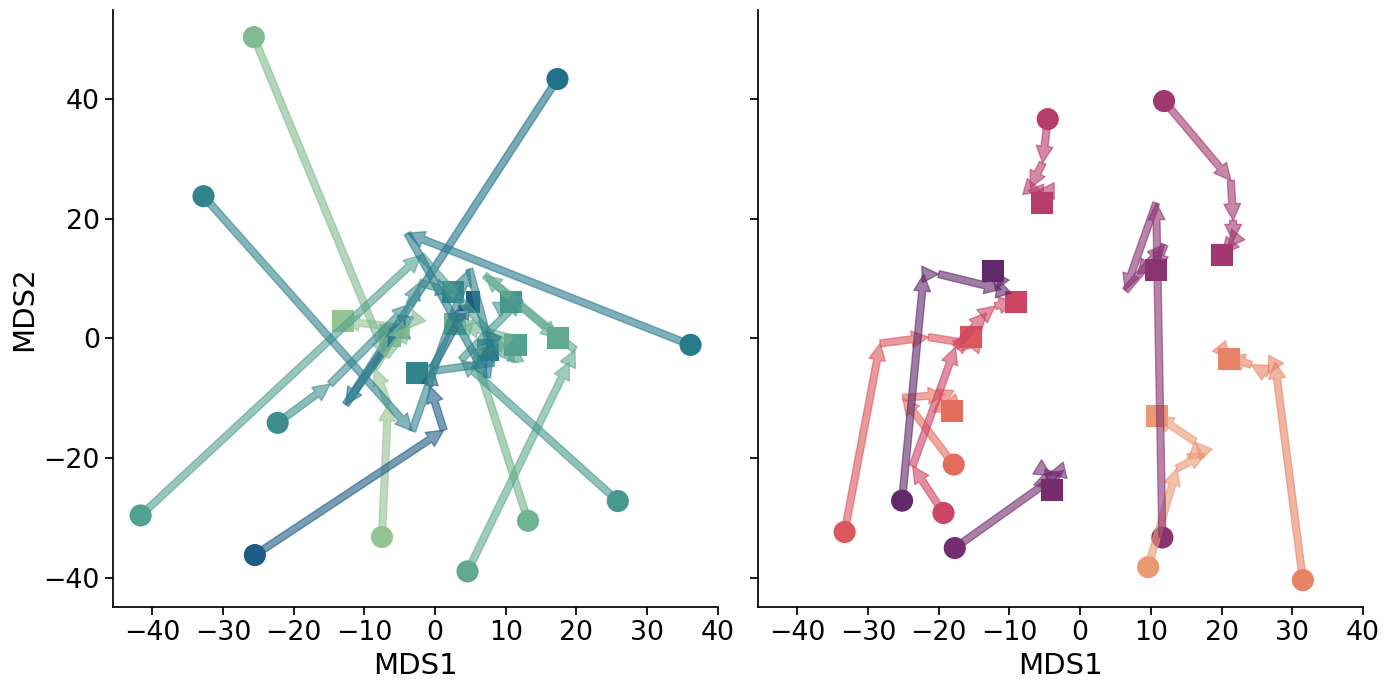

In [117]:
"Metaanalysis_mds Glucose and Cricket"
arrow_days = [0, 6, 12, 18, 21, 24, 28]
scatter_days = [arrow_days[0], arrow_days[-2], arrow_days[-1]]
# arrow_sources = metaanalysis_md[metaanalysis_md.days.isin(scatter_days[1:])].source.unique()
arrow_sources = metaanalysis_md.groupby('source').days.apply(lambda x: any([d in set(x) for d in [24, 28]]) & (0 in set(x))).pipe(lambda x: x[x]).index

arrow_metaanalysis_mds = metaanalysis_mds_meaned[metaanalysis_mds_meaned.days.isin(arrow_days) & metaanalysis_mds_meaned.source.isin(arrow_sources)]


# Scatter
with sns.plotting_context('notebook', font_scale=1.75):
    g = sns.relplot(x='MDS1', y='MDS2', hue='source', col='media', height=7, col_order=['Glucose', 'Cricket'], palette=metaanalysis_mds_source_pal, 
                    style='days', markers={0: 'o', 24: 's', 28:'s'},data=arrow_metaanalysis_mds[arrow_metaanalysis_mds.days.isin(scatter_days)], s=300, legend=False)
    g.set_titles('')
    for ax, media in zip(g.axes.ravel(), g.col_names):
        sources = arrow_metaanalysis_mds[arrow_metaanalysis_mds.media.eq(media)].source.unique()
        for source in sources:
            coordinates = arrow_metaanalysis_mds[arrow_metaanalysis_mds.source.eq(source)].sort_values('days')[['MDS1', 'MDS2']].values
            color = metaanalysis_mds_source_pal[source]
            draw_arrow_series(coordinates, color=color, width=5, alpha=.6, ax=ax)
plt.tight_layout()
# Save
# plt.savefig('publication_figures/glucose_cricket_metaanalysis_mds', bbox_inches='tight', dpi=300)

plt.show()

In [112]:
"Plot divergence"
# Only analyze distances between samples in the same condition but from different sources
glucose_cricket_same_conditions = glucose_cricket_paired[glucose_cricket_paired.same_media & glucose_cricket_paired.same_days & ~glucose_cricket_paired.same_Sample & ~glucose_cricket_paired.same_source]
# Dereplicate
derep_glucose_cricket_same_conditions = derep_pairs(glucose_cricket_same_conditions.groupby(['sample1_source', 'sample2_source', 'sample1_days', 'sample1_media']).distance.mean().reset_index(), 'sample1_source', 'sample2_source')
derep_glucose_cricket_same_conditions.head()

,sample1_source,sample2_source,sample1_days,sample1_media,distance
0,bittleston_M01,bittleston_M02,0,Cricket,55.010272
1,bittleston_M01,bittleston_M02,3,Cricket,36.436105
2,bittleston_M01,bittleston_M02,6,Cricket,35.089606
3,bittleston_M01,bittleston_M02,9,Cricket,34.295551
4,bittleston_M01,bittleston_M02,12,Cricket,35.695127


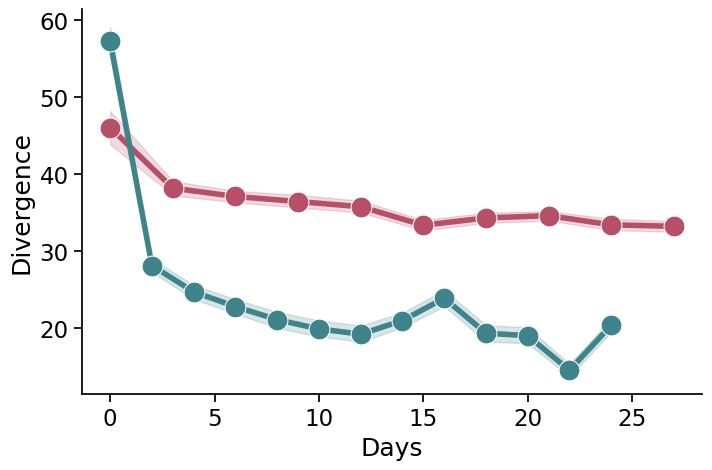

In [118]:
"Within condition convergence over time"
plt.figure(figsize=(8, 5))
glucose_cricket_pal = {media: np.array(sns.color_palette(metaanalysis_mds_study_map[study])).mean(0) for study, media in zip(['bittleston', 'goldford'], ['Cricket', 'Glucose'])}
derep_glucose_cricket_same_conditions_lt29 = derep_glucose_cricket_same_conditions[derep_glucose_cricket_same_conditions.sample1_days.lt(29)]

with sns.plotting_context('notebook', font_scale=1.5):
    sns.lineplot(x='sample1_days', y='distance', hue='sample1_media', data=derep_glucose_cricket_same_conditions_lt29, palette=glucose_cricket_pal, marker='o', ms=15, lw=4)
    plt.xlabel('Days')
    plt.ylabel('Divergence')
    plt.legend(bbox_to_anchor=(1, 1), title='Condition')
sns.despine()
plt.legend().set_visible(False)
# Save
# plt.savefig('publication_figures/glucose_cricket_divergence_timeseries', bbox_inches='tight', dpi=300)
    
plt.show()

In [150]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Figure1.xlsx') as fh:
    arrow_metaanalysis_mds.to_excel(fh, 'Fig 1e-f', index=False)
    derep_glucose_cricket_same_conditions_lt29.rename(columns={'sample1_days': 'days', 'sample1_media': 'media'}).to_excel(fh, 'Fig 1g', index=False)

# Figure 2: Divergence over time

## Trajectories

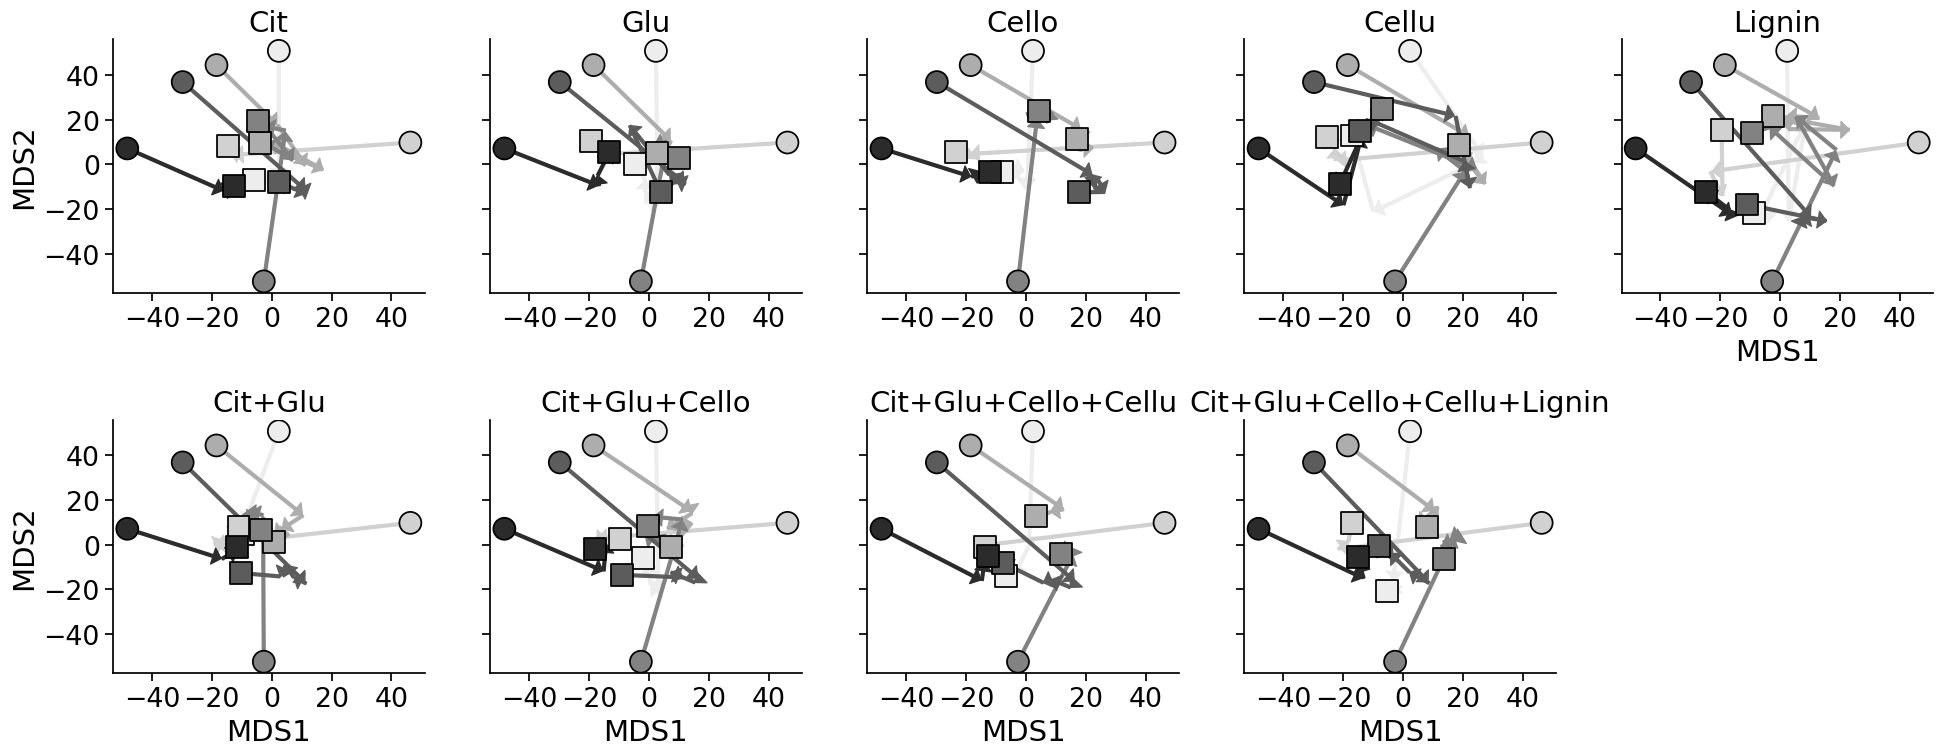

In [4]:
"MDS"
# Dataset includes synthetic duplicates of each T0 sample. Only want MDS on these samples once and then synthetically duplicate them
t1_on_samples = md[md.is_site_rep & md.days.gt(0) & md.is_site_rep].index
t0_samples = md[md.days.eq(0) & md.condition.eq('Cit') & md.is_site_rep].index
mds_samples = t1_on_samples.append(t0_samples)

# Compute MDS on samples together
mds_all_data = MDS(dissimilarity='precomputed', random_state=123, normalized_stress='auto').fit_transform(dist.loc[mds_samples, mds_samples])
mds_all = pd.DataFrame(mds_all_data, mds_samples, ['MDS1', 'MDS2']).join(md)

# Synethtically copy metadata 
mds_t0_syn_data = []
mds_t0 = mds_all.loc[mds_all.days.eq(0), ['MDS1', 'MDS2', 'site', 'days']]
for condition in md.condition.unique():
    mds_t0_copy = mds_t0.copy()
    mds_t0_copy['condition'] = condition
    mds_t0_syn_data.append(mds_t0_copy)
mds_t0_syn = pd.concat(mds_t0_syn_data)

mds_all_syn = pd.concat([mds_all[mds_all.days.gt(0)], mds_t0_syn]).rename(columns={'days': 'Days'})
# Map site codes to something more interpretable
site2pubsite = {s: f'S{s[3]}{s[2]}' for s in md.site.unique()}
mds_all_syn['Source'] = mds_all_syn.site.map(site2pubsite)
### GRAY PALETTE
site_pal = dict(zip(md.site.unique(), sns.color_palette('Greys', 6)))
site_pub_pal = {site2pubsite[site]: c for site, c in site_pal.items()}
hue_order = [site2pubsite[site] for site in sites]
# Have empty plot
# col_order = ['Cit', 'Glu', 'Cello', 'Cellu', 'Lignin', None, 'Cit+Glu', 'Cit+Glu+Cello', 'Cit+Glu+Cello+Cellu', 'Cit+Glu+Cello+Cellu+Lignin']
col_order = ['Cit', 'Glu', 'Cello', 'Cellu', 'Lignin', 'Cit+Glu', 'Cit+Glu+Cello', 'Cit+Glu+Cello+Cellu', 'Cit+Glu+Cello+Cellu+Lignin']

"Convergence across conditions"
with sns.plotting_context('notebook', font_scale=1.75):
    mds_scatter = mds_all_syn[mds_all_syn.Days.isin([0, 33])]
    g = sns.relplot(x='MDS1', y='MDS2', hue='Source', col='condition', style='Days', markers=['o', 's'], height=4, col_wrap=5, data=mds_scatter, kind='scatter', col_order=col_order,s=250, palette=site_pub_pal, hue_order=hue_order, legend=False, edgecolor='k', zorder=5, facet_kws={'sharex': False})
    g.set_titles('{col_name}')

    # Draw lines
    for ax, condition in zip(g.axes.ravel(), g.col_names):
        condition_mds = mds_all_syn[mds_all_syn.condition.eq(condition)]
        condition_sites = condition_mds[condition_mds.condition.eq(condition)].site.unique()
        for site in condition_sites:
            coordinates = condition_mds[condition_mds.site.eq(site)].sort_values('Days')[['MDS1', 'MDS2']].drop_duplicates().values
            color = np.array(site_pal[site])
            draw_arrow_series(coordinates, color=color, width=2, headlength=6, shrink=.01, ax=ax, zorder=-1)
#     sns.move_legend(g, 'right', markerscale=2, bbox_to_anchor=(.1, .25))
# Remove empty plot
# g.axes.ravel()[5].set_visible(False)
plt.subplots_adjust(hspace=.5)
# plt.savefig('publication_figures/mds_trajectories_asv_gray', bbox_inches='tight', dpi=300, transparent=True)
plt.savefig('publication_figures/Fig2-b-c.svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [5]:
"Linear regression between conditions and distances"
linregress_stats = derep_same_conditions[derep_same_conditions.sample1_days.gt(0)].sort_values(['sample1_days', 'sample1_condition_number']).groupby(['sample1_days', 'sample1_condition_type']).apply(lambda x: pd.Series(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr'], linregress(x.sample1_condition_number, x.distance, 'greater'))))).reset_index()
# linregress_stats['plot_pvalue'] = -np.log10(linregress_stats.pvalue)
# linregress_stats['pos_sig'] = linregress_stats.slope.gt(0) & linregress_stats.pvalue.lt(.05)
# linregress_stats.groupby('sample1_condition_type').pos_sig.agg(['sum', 'mean'])
linregress_stats['condition_type'] = linregress_stats.sample1_condition_type.str.capitalize()
linregress_stats

,sample1_days,sample1_condition_type,slope,intercept,rvalue,pvalue,stderr,condition_type
0,3,mixed,0.109726,25.280874,0.044259,4.186497e-01,0.528043,Mixed
1,3,single,1.540524,19.589436,0.701507,7.839361e-06,0.295762,Single
2,6,mixed,1.198950,16.955063,0.479992,8.612403e-04,0.355476,Mixed
3,6,single,1.707497,20.345374,0.579697,2.871818e-05,0.379487,Single
4,9,mixed,1.205912,13.442442,0.498415,5.318139e-04,0.340268,Mixed
5,9,single,1.433946,18.513521,0.424294,1.067296e-03,0.441719,Single
6,12,mixed,0.810015,16.936736,0.289129,1.252720e-02,0.352152,Mixed
7,12,single,1.715693,20.018968,0.552388,1.388735e-07,0.303030,Single
8,33,mixed,0.971607,14.747090,0.481033,5.001820e-05,0.232517,Mixed
9,33,single,1.564698,19.516483,0.669917,2.471755e-11,0.202958,Single


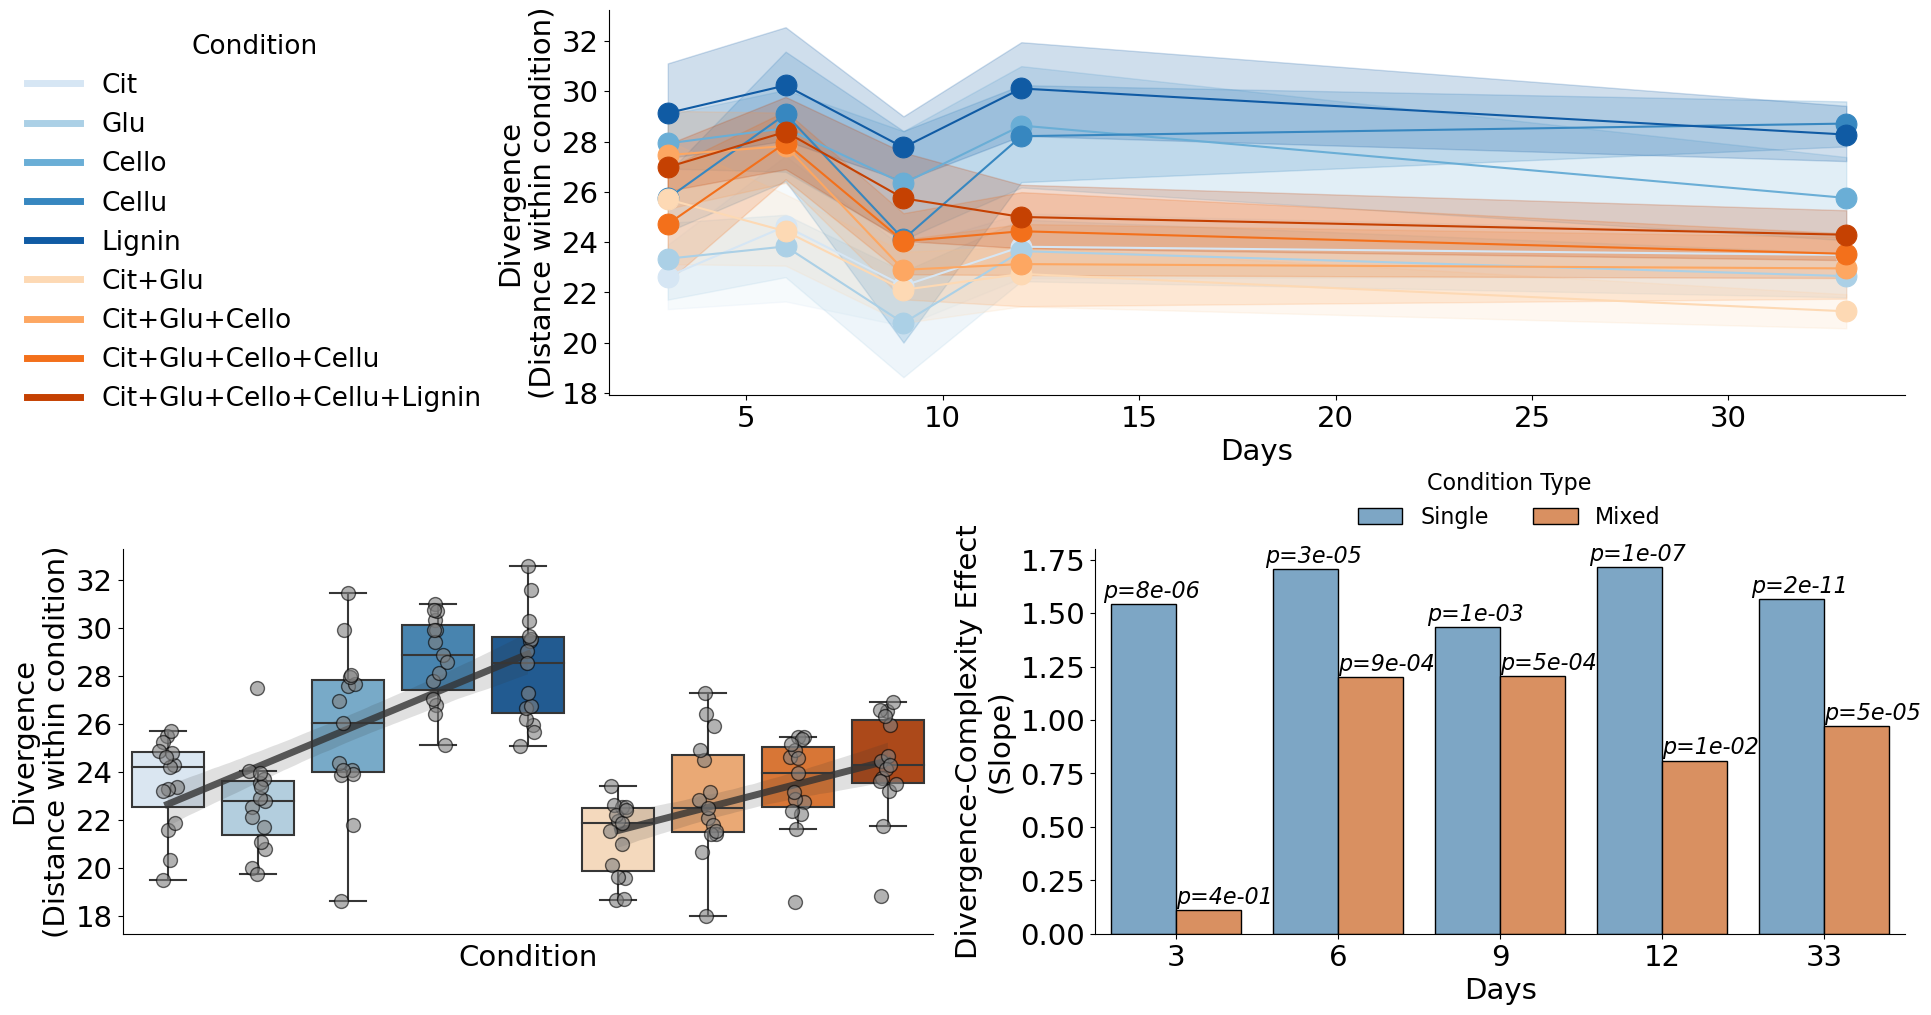

In [29]:
"Divergence timeseries and final timepoint"
fontsize = 12*1.75
with plt.rc_context({'font.size': fontsize}):
    
    fig, axs = plt.subplot_mosaic([['.', 'timeseries', 'timeseries', 'timeseries'], ['boxplot', 'boxplot', 'bars', 'bars']], figsize=(23, 12), gridspec_kw={'wspace': .5, 'hspace': .4})

    ## Timeseries
    ax1 = axs['timeseries']
    sns.lineplot(x='sample1_days', y='distance', hue='sample1_condition', data=derep_same_conditions[derep_same_conditions.sample1_days.gt(0)], marker='o', hue_order=conditions.values(), ms=15, palette=condition_pal, mec=None, ax=ax1)
    ax1.set_ylabel('Divergence\n(Distance within condition)')
    ax1.set_xlabel('Days')

    leg = ax1.legend(title='Condition', frameon=False, bbox_to_anchor=(-.08, 1), fontsize=19,  title_fontsize=19)#, bbox_to_anchor=(-.04, .7))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5)

    ## Final timepoint boxplot
    ax2 = axs['boxplot']
    derep_final = derep_same_conditions[derep_same_conditions.sample1_transfer.eq('T10')].reset_index(drop=True)
    derep_final['sample1_condition_number'] = derep_final.sample1_condition_number - 2

    kwargs = dict(x='sample1_condition', y='distance', data=derep_final, order=conditions.values(), ax=ax2)
    sns.boxplot(**kwargs, palette=condition_pal, showfliers=False)
    sns.stripplot(**kwargs, edgecolor='k', size=10, linewidth=1, color='.5', alpha=.6)

    # Lines
    kwargs = dict(x='sample1_condition_number', y='distance', scatter=False, line_kws={'linewidth': 5, 'alpha': .8}, color='.2', ax=ax2)
    sns.regplot(**kwargs, data=derep_final[derep_final.sample1_condition_type.eq('single')])
    sns.regplot(**kwargs, data=derep_final[derep_final.sample1_condition_type.eq('mixed')])
    ax2.set_xticks([])
    ax2.set_xlabel('Condition')
    ax2.set_ylabel('Divergence\n(Distance within condition)')

    ## Slope bars
    ax3 = axs['bars']
    single_color = np.mean([v for k, v in condition_pal.items() if '+' not in k], 0)
    mixed_color = np.mean([v for k, v in condition_pal.items() if '+' in k], 0)
    single_mixed_pal = dict(zip(['Single', 'Mixed'], [single_color, mixed_color]))

    sns.barplot(x='sample1_days', y='slope', hue='condition_type', data=linregress_stats, edgecolor='k', hue_order=['Single', 'Mixed'], palette=single_mixed_pal, ax=ax3)
    for i, day in enumerate(sorted(linregress_stats.sample1_days.unique())):
        for offset, condition in enumerate(['single', 'mixed']):
            condition_stats = linregress_stats[linregress_stats.sample1_days.eq(day) & linregress_stats.sample1_condition_type.eq(condition)].squeeze()
            pval = f'p={condition_stats.pvalue:.0e}'
            x_pos = i - .15 + offset * .45
            y_pos = condition_stats.slope + .03
            p_color = single_mixed_pal[condition.capitalize()]
            ax3.annotate(pval, (x_pos, y_pos), horizontalalignment='center', fontsize=16, fontstyle='italic')#, color=p_color)
    
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Divergence-Complexity Effect\n(Slope)')
    ax3.legend(bbox_to_anchor=(.3, 1), frameon=False, title='Condition Type', ncol=2, fontsize=16, title_fontsize=16)


sns.despine()
# plt.savefig('publication_figures/divergence_timeseries+finaltimepoint', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig('publication_figures/Fig2-d-f.pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

In [18]:
paired[paired.same_transfer & paired.sample1_transfer.eq('T-1') & (~paired.same_Sample) & paired.same_is_site_rep & (~paired.same_site)].distance.agg(['mean', 'std'])

mean    58.101872
std      3.475036
Name: distance, dtype: float64

In [151]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Figure2.xlsx') as fh:
    mds_all_syn[['MDS1', 'MDS2', 'condition', 'Days', 'site', 'condition_type']].to_excel(fh, 'Fig 2b-c')
    derep_same_conditions[derep_same_conditions.sample1_days.gt(0)].rename(columns={c: c.split('sample1_')[-1] for c in derep_same_conditions if 'site' not in c}).to_excel(fh, 'Fig 2d', index=False)
    derep_final.rename(columns={c: c.replace('sample1_', '') for c in derep_same_conditions if 'site' not in c}).to_excel(fh, 'Fig 2e', index=False)
    linregress_stats.rename(columns={c: c.replace('sample1_', '') for c in linregress_stats}).to_excel(fh, 'Fig 2f', index=False)

## Supplementary: Divergence without HF1P15 and HF3H15 (which are missing samples from day 3, 6, and 9)

In [23]:
"Filter out HF1P and HF3H"
derep_same_conditions_nohf1p_hf3h = derep_same_conditions[(~derep_same_conditions.sample1_site.isin(['HF1P15', 'HF3H15'])) & (~derep_same_conditions.sample2_site.isin(['HF1P15', 'HF3H15']))]

"Linear regression between conditions and distances without HF1P and HF3H"
linregress_stats_nohf1p_hf3h = derep_same_conditions_nohf1p_hf3h[derep_same_conditions_nohf1p_hf3h.sample1_days.gt(0)].sort_values(['sample1_days', 'sample1_condition_number']).groupby(['sample1_days', 'sample1_condition_type']).apply(lambda x: pd.Series(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr'], linregress(x.sample1_condition_number, x.distance, 'greater'))))).reset_index()
# linregress_stats_nohf1p_hf3h['plot_pvalue'] = -np.log10(linregress_stats_nohf1p_hf3h.pvalue)
# linregress_stats_nohf1p_hf3h['pos_sig'] = linregress_stats_nohf1p_hf3h.slope.gt(0) & linregress_stats_nohf1p_hf3h.pvalue.lt(.05)
# linregress_stats.groupby('sample1_condition_type').pos_sig.agg(['sum', 'mean'])
linregress_stats_nohf1p_hf3h['condition_type'] = linregress_stats_nohf1p_hf3h.sample1_condition_type.str.capitalize()

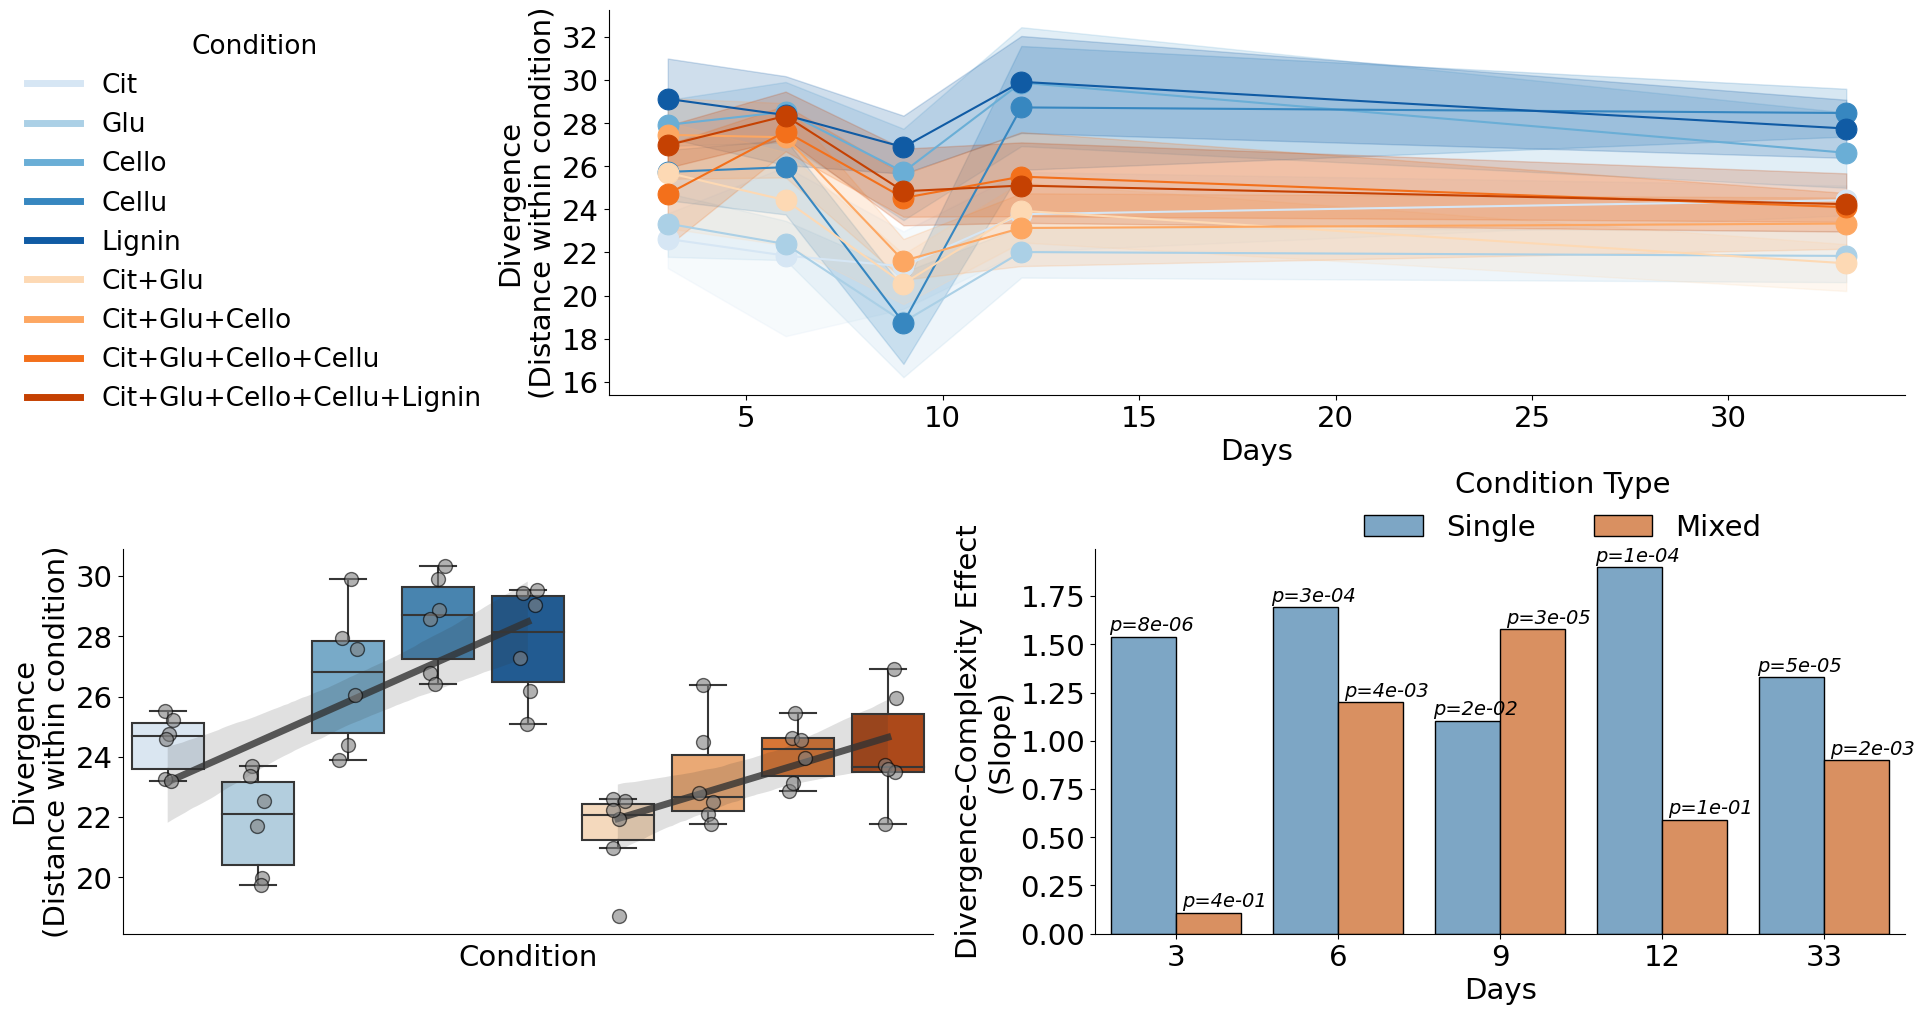

In [153]:
"Divergence timeseries and final timepoint without HF1P and HF3H since these are missing samples from days 3, 6, and 9"
fontsize = 12*1.75
with plt.rc_context({'font.size': fontsize}):
    
    fig, axs = plt.subplot_mosaic([['.', 'timeseries', 'timeseries', 'timeseries'], ['boxplot', 'boxplot', 'bars', 'bars']], figsize=(23, 12), gridspec_kw={'wspace': .5, 'hspace': .4})

    ## Timeseries
    ax1 = axs['timeseries']
    sns.lineplot(x='sample1_days', y='distance', hue='sample1_condition', data=derep_same_conditions_nohf1p_hf3h[derep_same_conditions_nohf1p_hf3h.sample1_days.gt(0)], marker='o', hue_order=conditions.values(), ms=15, palette=condition_pal, mec=None, ax=ax1)
    ax1.set_ylabel('Divergence\n(Distance within condition)')
    ax1.set_xlabel('Days')

    leg = ax1.legend(title='Condition', frameon=False, bbox_to_anchor=(-.08, 1), fontsize=19,  title_fontsize=19)#, bbox_to_anchor=(-.04, .7))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5)

    ## Final timepoint boxplot
    ax2 = axs['boxplot']
    derep_final_nohf1p_hf3h = derep_same_conditions_nohf1p_hf3h[derep_same_conditions_nohf1p_hf3h.sample1_transfer.eq('T10')].reset_index(drop=True)
    derep_final_nohf1p_hf3h['sample1_condition_number'] = derep_final_nohf1p_hf3h.sample1_condition_number - 2

    kwargs = dict(x='sample1_condition', y='distance', data=derep_final_nohf1p_hf3h, order=conditions.values(), ax=ax2)
    sns.boxplot(**kwargs, palette=condition_pal, showfliers=False)
    sns.stripplot(**kwargs, edgecolor='k', size=10, linewidth=1, color='.5', alpha=.6)

    # Lines
    kwargs = dict(x='sample1_condition_number', y='distance', scatter=False, line_kws={'linewidth': 5, 'alpha': .8}, color='.2', ax=ax2)
    sns.regplot(**kwargs, data=derep_final_nohf1p_hf3h[derep_final_nohf1p_hf3h.sample1_condition_type.eq('single')])
    sns.regplot(**kwargs, data=derep_final_nohf1p_hf3h[derep_final_nohf1p_hf3h.sample1_condition_type.eq('mixed')])
    ax2.set_xticks([])
    ax2.set_xlabel('Condition')
    ax2.set_ylabel('Divergence\n(Distance within condition)')

    ## Slope bars
    ax3 = axs['bars']
    single_color = np.mean([v for k, v in condition_pal.items() if '+' not in k], 0)
    mixed_color = np.mean([v for k, v in condition_pal.items() if '+' in k], 0)
    single_mixed_pal = dict(zip(['Single', 'Mixed'], [single_color, mixed_color]))

    sns.barplot(x='sample1_days', y='slope', hue='condition_type', data=linregress_stats_nohf1p_hf3h, edgecolor='k', hue_order=['Single', 'Mixed'], palette=single_mixed_pal, ax=ax3)
    for i, day in enumerate(sorted(linregress_stats_nohf1p_hf3h.sample1_days.unique())):
        for offset, condition in enumerate(['single', 'mixed']):
            condition_stats = linregress_stats_nohf1p_hf3h[linregress_stats_nohf1p_hf3h.sample1_days.eq(day) & linregress_stats_nohf1p_hf3h.sample1_condition_type.eq(condition)].squeeze()
            pval = f'p={condition_stats.pvalue:.0e}'
            x_pos = i - .15 + offset * .45
            y_pos = condition_stats.slope + .03
            ax3.annotate(pval, (x_pos, y_pos), horizontalalignment='center', fontsize=14, fontstyle='italic')
    plt.xlabel('Days')
    plt.ylabel('Divergence-Complexity Effect\n(Slope)')
    plt.legend(bbox_to_anchor=(.3, .95), frameon=False, title='Condition Type', ncol=2)

sns.despine()
# plt.savefig('publication_figures/divergence_timeseries+finaltimepoint_no-HF1P-or-HF3H', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

In [12]:
linregress_stats_nohf1p_hf3h

,sample1_days,sample1_condition_type,slope,intercept,rvalue,pvalue,stderr,plot_pvalue,pos_sig,condition_type
0,3,mixed,0.109726,25.280874,0.044259,0.418650,0.528043,0.378149,False,Mixed
1,3,single,1.540524,19.589436,0.701507,0.000008,0.295762,5.105719,True,Single
2,6,mixed,1.201003,16.723201,0.529041,0.003928,0.410718,2.405774,True,Mixed
3,6,single,1.693272,18.817015,0.649422,0.000297,0.422714,3.526660,True,Single
4,9,mixed,1.578235,9.469211,0.724799,0.000031,0.319843,4.510321,True,Mixed
5,9,single,1.103373,17.884744,0.370563,0.021909,0.522645,1.659373,True,Single
6,12,mixed,0.589727,19.411377,0.273663,0.097838,0.441896,1.009491,False,Mixed
7,12,single,1.900862,19.263096,0.617057,0.000141,0.458116,3.851964,True,Single
8,33,mixed,0.900183,15.643647,0.559316,0.002245,0.284442,2.648830,True,Mixed
9,33,single,1.329206,20.506748,0.650143,0.000050,0.293569,4.297794,True,Single


In [154]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Extended_Data_Figure2.xlsx') as fh:
    derep_same_conditions_nohf1p_hf3h[derep_same_conditions_nohf1p_hf3h.sample1_days.gt(0)].rename(columns={c: c.split('sample1_')[-1] for c in derep_same_conditions if 'site' not in c}).to_excel(fh, 'Extended Fig 2a', index=False)
    derep_final_nohf1p_hf3h.rename(columns={c: c.replace('sample1_', '') for c in derep_same_conditions if 'site' not in c}).to_excel(fh, 'Extended Fig 2b', index=False)
    linregress_stats_nohf1p_hf3h.rename(columns={c: c.replace('sample1_', '') for c in linregress_stats}).to_excel(fh, 'Fig 2f', index=False)

## Supplementary: Family divergence effect

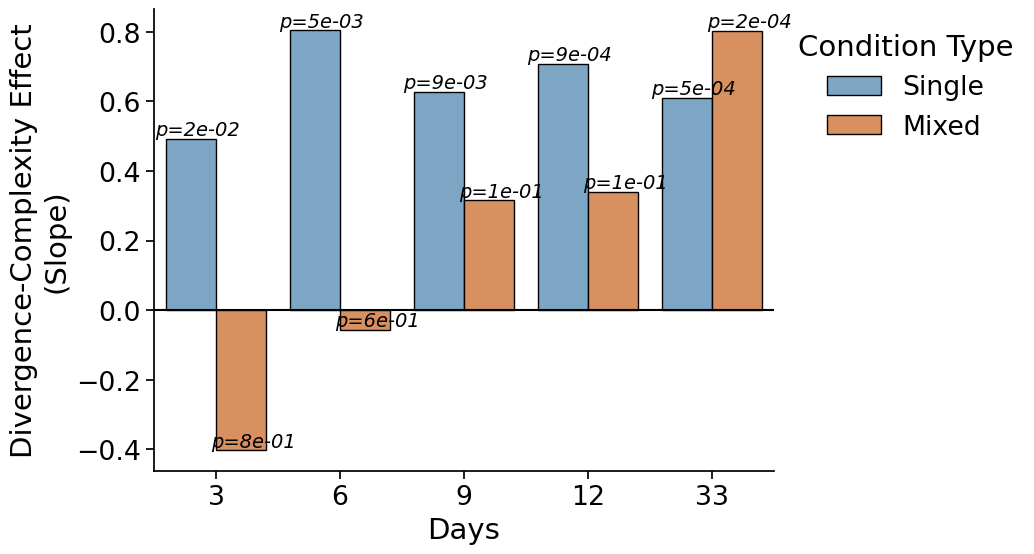

In [156]:
family = collapse(asv, taxa, 'Family')
dist_family = pd.DataFrame(squareform(pdist(family.add(1).apply(clr).T)), family.columns, family.columns)
paired_family = pair_md(dist_family, md.reset_index())
# Compute 'convergence' on same day across sites within condition
same_conditions_family = paired_family[paired_family.same_condition & paired_family.same_days & (~paired_family.same_site)]
# Dereplicate replicates (take mean of T10 distances and then only keep one comparison)
derep_same_conditions_family = derep_pairs(same_conditions_family.groupby(['sample1_site', 'sample2_site', 'sample1_condition', 'sample1_condition_number', 'sample1_condition_type', 'sample1_days', 'sample1_transfer']).distance.mean().reset_index(), 'sample1_site', 'sample2_site')

linregress_stats_family = derep_same_conditions_family[derep_same_conditions_family.sample1_days.gt(0)].sort_values(['sample1_days', 'sample1_condition_number']).groupby(['sample1_days', 'sample1_condition_type']).apply(lambda x: pd.Series(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr'], linregress(x.sample1_condition_number, x.distance, 'greater'))))).reset_index()
# linregress_stats_family['plot_pvalue'] = -np.log10(linregress_stats_family.pvalue)
# linregress_stats_family['pos_sig'] = linregress_stats_family.slope.gt(0) & linregress_stats_family.pvalue.lt(.05)
# linregress_stats.groupby('sample1_condition_type').pos_sig.agg(['sum', 'mean'])
linregress_stats_family['condition_type'] = linregress_stats_family.sample1_condition_type.str.capitalize()
single_color = np.mean([v for k, v in condition_pal.items() if '+' not in k], 0)
mixed_color = np.mean([v for k, v in condition_pal.items() if '+' in k], 0)
single_mixed_pal = dict(zip(['Single', 'Mixed'], [single_color, mixed_color]))
plt.figure(figsize=(8, 6))
with sns.plotting_context('notebook', font_scale=1.75):
    sns.barplot(x='sample1_days', y='slope', hue='condition_type', data=linregress_stats_family, edgecolor='k', palette=single_mixed_pal, hue_order=['Single', 'Mixed'])
    for i, day in enumerate(sorted(linregress_stats_nohf1p_hf3h.sample1_days.unique())):
        for offset, condition in enumerate(['single', 'mixed']):
            condition_stats = linregress_stats_family[linregress_stats_family.sample1_days.eq(day) & linregress_stats_family.sample1_condition_type.eq(condition)].squeeze()
            pval = f'p={condition_stats.pvalue:.0e}'
            x_pos = i - .15 + offset * .45
            y_pos = condition_stats.slope + .01
            plt.annotate(pval, (x_pos, y_pos), horizontalalignment='center', fontsize=14, fontstyle='italic')
    plt.xlabel('Days')
    plt.ylabel('Divergence-Complexity Effect\n(Slope)')
    plt.legend(bbox_to_anchor=(1, 1), frameon=False, title='Condition Type')
sns.despine()
plt.axhline(0, color='k')
# plt.savefig('publication_figures/divergence_slope_days_family', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [157]:
linregress_stats_family

,sample1_days,sample1_condition_type,slope,intercept,rvalue,pvalue,stderr,condition_type
0,3,mixed,-0.402164,14.267338,-0.211156,0.839024,0.396902,Mixed
1,3,single,0.493120,7.667123,0.361689,0.024768,0.240211,Single
2,6,mixed,-0.056291,11.180812,-0.028448,0.569166,0.320865,Mixed
3,6,single,0.804610,8.802552,0.394608,0.004854,0.296233,Single
4,9,mixed,0.315937,6.716778,0.193133,0.116233,0.260374,Mixed
5,9,single,0.627630,7.818409,0.335805,0.008560,0.254106,Single
6,12,mixed,0.340935,6.743416,0.153110,0.121415,0.288936,Mixed
7,12,single,0.707340,8.276018,0.355224,0.000882,0.217858,Single
8,33,mixed,0.802002,3.012541,0.444194,0.000189,0.212404,Mixed
9,33,single,0.610935,8.571270,0.374006,0.000474,0.177310,Single


In [158]:
"Save source data"
linregress_stats_family.rename(columns={c: c.replace('sample1_', '') for c in linregress_stats}).to_excel('publication_figures_source_data/Extended_Data_Figure3.xlsx', 'Extended Fig 3', index=False)

## Supplementary: Divergence within replicates

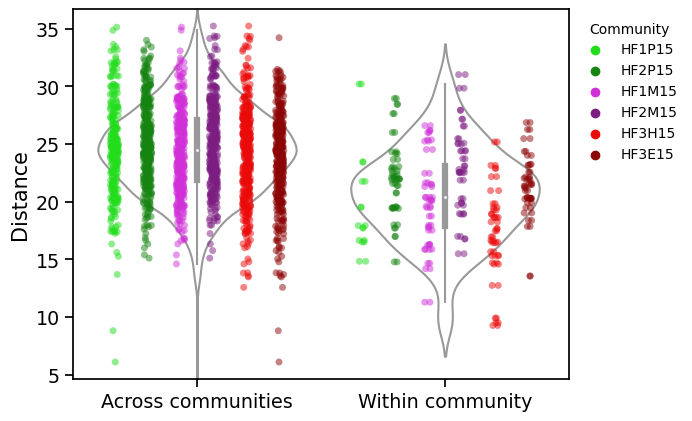

In [35]:
"Distance within site between replicates vs. distance across sites"
t10_within_between = paired[(~paired.same_Sample) & paired.same_condition & paired.sample1_transfer.eq('T10') & paired.same_transfer & ((paired.same_site & (~paired.same_replicate)) | (~paired.same_site))]
kwargs = dict(x='same_site', y='distance', data=t10_within_between)
with sns.plotting_context('notebook', font_scale=1.25):
    sns.violinplot(**kwargs, color='w')
    sns.stripplot(**kwargs, hue='sample1_site', palette=site_pal, hue_order=sites, alpha=.5, dodge=True)
    plt.xticks([0, 1], labels=['Across communities', 'Within community'])
    plt.xlabel('')
    plt.ylabel('Distance')
plt.legend(bbox_to_anchor=(1, 1), title='Community', frameon=False)
# plt.savefig('publication_figures/divergence_within_replicates-violin', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [18]:
t10_within_between.groupby('same_site').size().div(2)

same_site
False    1066.0
True      142.0
dtype: float64

In [33]:
"Final timepoint MDS on each condition independently"
mds_data = []
for condition in md.condition.unique():
    condition_samples = md[md.condition.eq(condition) & md.days.eq(33)].index
    condition_dist = dist.loc[condition_samples, condition_samples]
    mds_condition_data = MDS(dissimilarity='precomputed', normalized_stress='auto', random_state=123).fit_transform(condition_dist)
    mds_condition = pd.DataFrame(mds_condition_data, condition_dist.columns, ['MDS1', 'MDS2']).join(md)
    mds_data.append(mds_condition)
# Combine
mds_independent = pd.concat(mds_data).reset_index()
# Dereplicate 
mds_independent_derep = mds_independent.groupby(['condition_name', 'condition', 'site', 'days', 'condition_type', 'condition_number'])[['MDS1', 'MDS2']].mean().reset_index()
# T10 is from same replicate as others from site
mds_independent_site_rep = mds_independent[mds_independent.is_site_rep]
mds_independent.head()

,Sample,MDS1,MDS2,condition_name,site,replicate,transfer,condition,days,condition_type,condition_number,depth,site_rep,is_site_rep,Cit,Glu,Cello,Cellu,Lignin
0,C10-HF1M15-R1-T10_S407,-10.008542,-18.957064,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True
1,C10-HF1M15-R2-T10_S434,8.617283,15.092506,C10,HF1M15,R2,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,8053,R1,False,True,True,True,True,True
2,C10-HF1M15-R3-T10_S188,13.695820,12.094370,C10,HF1M15,R3,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,10024,R1,False,True,True,True,True,True
3,C10-HF1P15-R1-T10_S455,7.974622,-16.335881,C10,HF1P15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11255,R2,False,True,True,True,True,True
4,C10-HF1P15-R2-T10_S383,0.220125,-17.084504,C10,HF1P15,R2,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,9599,R2,True,True,True,True,True,True


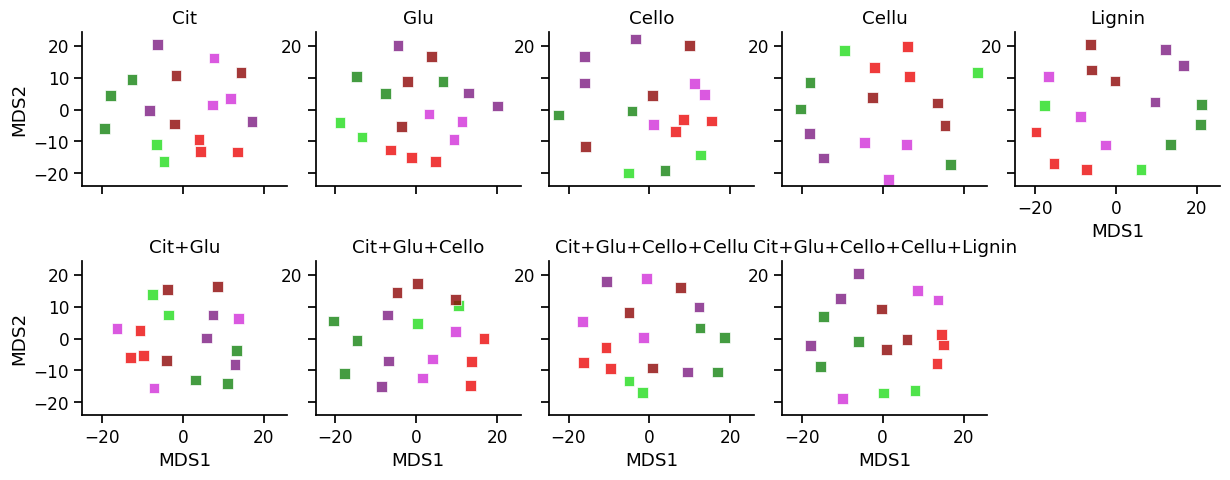

In [166]:
"Convergence across conditions just final timepoint"
with sns.plotting_context('notebook', font_scale=1.1):
    g = sns.relplot(x='MDS1', y='MDS2', hue='site', col='condition', marker='s', height=2.5, col_wrap=5, data=mds_independent, kind='scatter', col_order=conditions.values(),alpha=.8, palette=site_pal, hue_order=sites, s=60, legend=False)
    g.set_titles('{col_name}')
plt.savefig('publication_figures/divergence_within_replicates-mds', bbox_inches='tight', transparent=True, dpi=300)
plt.show()

In [36]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Extended_Data_Figure5.xlsx') as fh:
    mds_independent[['MDS1', 'MDS2', 'condition', 'replicate', 'site', 'condition_type']].to_excel(fh, 'Extended Fig 5a', index=False)
    t10_within_between[['sample1', 'sample2', 'distance', 'sample1_site', 'sample1_replicate', 'sample1_condition', 'sample1_condition_type', 
                        'same_condition', 'same_site', 'same_replicate']].rename(columns={c: c.split('sample1_')[-1] for c in t10_within_between}).to_excel(fh, 'Extended Fig 5b', index=False)

# Figure 3: Diversity and divergence

In [24]:
"Alpha diversity and divergence data"
# Take average diversity over T10 replicates
alpha_derep = alpha.groupby(['site', 'condition', 'days'])[['shannon', 'richness']].mean()
# Mean distance from one site within a condition to all other sites
mean_divergence = same_conditions[~same_conditions.same_site].rename(columns={f'sample1_{c}': c for c in ['site', 'condition', 'days']}).groupby(['site', 'condition', 'days']).distance.mean()
# Combine
alpha_convergence = pd.concat([alpha_derep, mean_divergence], axis=1).reset_index().rename(columns={'condition': 'Condition', 'days': 'Days'})
alpha_div_corr = spearmanr(alpha_convergence[['distance', 'shannon']], nan_policy='omit')
alpha_div_corr_by_day = alpha_convergence.groupby('Days')[['shannon', 'distance']].corr('spearman').loc[:, 'shannon'].loc[:, 'distance']
# Slopes
alpha_convergence_linregress = alpha_convergence.dropna().groupby('Days').apply(lambda x: pd.Series(linregress(x[['shannon', 'distance']]), ['slope', 'intercept', 'r', 'p', 'stderr'])).reset_index()
print(alpha_div_corr)
alpha_convergence.head()

SignificanceResult(statistic=0.786841847393904, pvalue=5.279769952308316e-60)


,site,Condition,Days,shannon,richness,distance
0,HF1M15,Cello,0,5.156857,273.0,57.405879
1,HF1M15,Cello,3,1.274686,25.0,27.813879
2,HF1M15,Cello,6,1.074407,8.0,25.937393
3,HF1M15,Cello,9,0.802728,12.0,23.269794
4,HF1M15,Cello,12,0.914483,20.0,25.152944


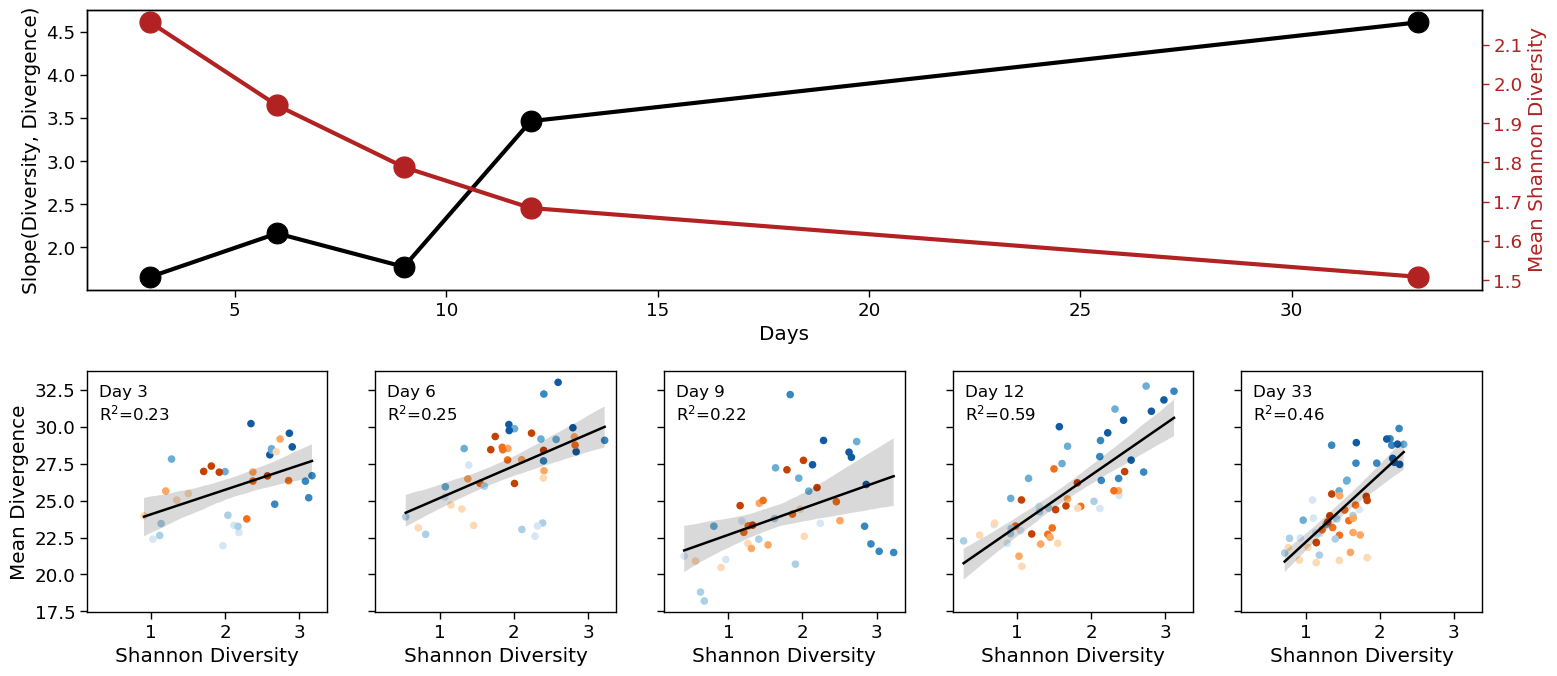

In [25]:
"One figure"
alpha_convergence_linregress_after_t0 = alpha_convergence_linregress[alpha_convergence_linregress.Days.gt(0)]
mean_alpha = alpha.groupby('days').shannon.mean()[[3, 6, 9, 12, 33]]


# Convergence and initial div. Shannon "differs" within condition for initial points bc of synthetic samples and stochasticity of rarefaction. Just take mean to dereplicate
alpha_convergence_T0 = alpha_convergence[alpha_convergence.Days.eq(0)].groupby('site')[['shannon', 'richness', 'distance']].mean()
alpha_convergence_T0 = alpha_convergence_T0.rename(columns={c: f'{c}_initial' for c in alpha_convergence_T0.columns}).reset_index()
alpha_convergence_with_initial = alpha_convergence.merge(alpha_convergence_T0)

with sns.plotting_context('paper', font_scale=1.5):
    days = [3, 6, 9, 12, 33]
    fig = plt.figure(figsize=(18, 8))
    gs_top = fig.add_gridspec(2, 5, wspace=1.5)
#     ax1 = fig.add_subplot(gs_top[0, :2])
    ax1 = fig.add_subplot(gs_top[0, :])
    kwargs = {'ms': 15, 'marker': 'o', 'lw': 3}
    sns.lineplot(x='Days', y='slope', data=alpha_convergence_linregress_after_t0, color='k', mec=None, ax=ax1, **kwargs)
    ax1.set_ylabel('Slope(Diversity, Divergence)')
    ax2 = ax1.twinx()
    shannon_color = 'firebrick'
    ax2.plot(mean_alpha, c=shannon_color, **kwargs)

    ax2.set_ylabel('Mean Shannon Diversity', color=shannon_color)
    ax2.tick_params('y', colors=shannon_color)
    
    # Initial richness and divergence
#     ax3 = fig.add_subplot(gs_top[0, 2:4])
#     kwargs = dict(x='richness_initial', y='distance', data=alpha_convergence_with_initial[alpha_convergence_with_initial.Days.eq(33)], ax=ax3)
#     sns.scatterplot(**kwargs, hue='Condition', palette=condition_pal, hue_order=conditions.values(), s=40, ec=None)
#     sns.regplot(**kwargs, color='k', scatter=None)
#     ax3.set_xlabel('Initial Richness')
#     ax3.set_ylabel('Final Mean Divergence')
#     ax3.legend(bbox_to_anchor=(1, 1), frameon=False, title='Condition', fontsize=12)
    
    gs_bottom = fig.add_gridspec(2, 5, hspace=.3)
    for i, day in enumerate(days):
        if i == 0:
            ax = None
        ax = fig.add_subplot(gs_bottom[1, i], sharex=ax, sharey=ax)
        day_data = alpha_convergence[alpha_convergence.Days.eq(day)]
        kwargs = dict(x='shannon', y='distance', data=day_data, ax=ax)
        # Scatter
        sns.scatterplot(**kwargs, hue='Condition', palette=condition_pal, hue_order=conditions.values(), ec=None, s=30, legend=False)
        # Regression line
        sns.regplot(**kwargs, scatter=False, color='k')
        # Print rho
        rho = alpha_div_corr_by_day[day]
        annotation = f"""Day {day} 
R$^2$={rho**2:.2f}"""
        ax.annotate(annotation, (.05, .8), xycoords='axes fraction', fontsize=12)
        if i == 0:
            ylabel = 'Mean Divergence'
        else:
            ylabel = ''
            plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.set_xlabel('Shannon Diversity')
        ax.set_ylabel(ylabel)
        ax.set_box_aspect(1)
    

# plt.tight_layout()
# plt.savefig('publication_figures/diversity_divergence_timeseries', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig('publication_figures/Fig3-a-b.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [33]:
alpha_convergence_linregress

,Days,slope,intercept,r,p,stderr
0,0,3.043343,42.597725,0.292473,3.186401e-02,1.379892
1,3,1.660115,22.418445,0.487587,3.444995e-03,0.525488
2,6,2.163273,23.015146,0.520369,4.116235e-04,0.561304
3,9,1.776214,20.914268,0.442791,2.945074e-03,0.561714
4,12,3.462988,19.801074,0.770323,2.439535e-11,0.405395
5,33,4.608063,17.579186,0.743237,1.223295e-10,0.575220


In [204]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Figure3.xlsx') as fh:
    alpha_convergence_linregress_after_t0.set_index('Days').join(mean_alpha).to_excel(fh, 'Fig 3a')
    day_data.to_excel(fh, 'Fig 3b', index=False)

## Supplementary: Divergence and diversity without HF1P and HF3H (which are missing samples from day 3, 6, and 9)

In [200]:
"Alpha diversity and divergence data without HF1P and HF3H"
alpha_convergence_no_hf1p_or_hf3h = alpha_convergence[~alpha_convergence.site.isin(['HF1P15', 'HF3H15'])]
alpha_convergence_linregress_no_hf1p_or_hf3h = alpha_convergence_no_hf1p_or_hf3h.dropna().groupby('Days').apply(lambda x: pd.Series(linregress(x[['shannon', 'distance']]), ['slope', 'intercept', 'r', 'p', 'stderr'])).reset_index()
mean_alpha_no_hf1p_or_hf3h = alpha[~alpha.site.isin(['HF1P15', 'HF3H15'])].groupby('days').shannon.mean()[[3, 6, 9, 12, 33]]

alpha_div_corr_no_hf1p_or_hf3h = spearmanr(alpha_convergence_no_hf1p_or_hf3h[['distance', 'shannon']], nan_policy='omit')
alpha_div_corr_by_day_no_hf1p_or_hf3h = alpha_convergence_no_hf1p_or_hf3h.groupby('Days')[['shannon', 'distance']].corr('spearman').loc[:, 'shannon'].loc[:, 'distance']

alpha_convergence_linregress_after_t0_no_hf1p_or_hf3h = alpha_convergence_linregress_no_hf1p_or_hf3h[alpha_convergence_linregress_no_hf1p_or_hf3h.Days.gt(0)]


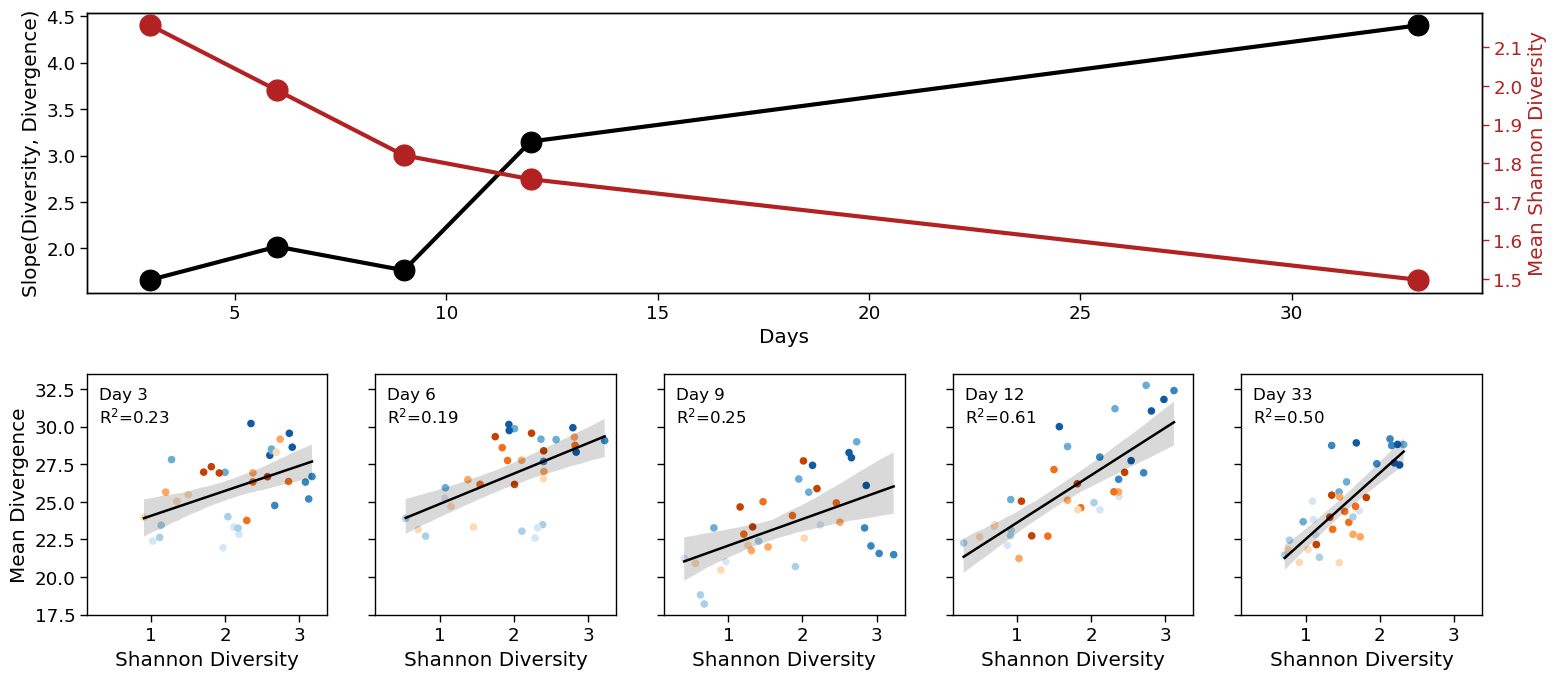

In [202]:
"Alpha diversity and divergence data without HF1P and HF3H"

with sns.plotting_context('paper', font_scale=1.5):
    days = [3, 6, 9, 12, 33]
    fig = plt.figure(figsize=(18, 8))
    gs_top = fig.add_gridspec(2, 5, wspace=1.5)
#     ax1 = fig.add_subplot(gs_top[0, :2])
    ax1 = fig.add_subplot(gs_top[0, :])
    kwargs = {'ms': 15, 'marker': 'o', 'lw': 3}
    sns.lineplot(x='Days', y='slope', data=alpha_convergence_linregress_after_t0_no_hf1p_or_hf3h, color='k', mec=None, ax=ax1, **kwargs)
    ax1.set_ylabel('Slope(Diversity, Divergence)')
    ax2 = ax1.twinx()
    shannon_color = 'firebrick'
    ax2.plot(mean_alpha_no_hf1p_or_hf3h, c=shannon_color, **kwargs)

    ax2.set_ylabel('Mean Shannon Diversity', color=shannon_color)
    ax2.tick_params('y', colors=shannon_color)
    
    gs_bottom = fig.add_gridspec(2, 5, hspace=.3)
    for i, day in enumerate(days):
        if i == 0:
            ax = None
        ax = fig.add_subplot(gs_bottom[1, i], sharex=ax, sharey=ax)
        day_data = alpha_convergence_no_hf1p_or_hf3h[alpha_convergence_no_hf1p_or_hf3h.Days.eq(day)]
        kwargs = dict(x='shannon', y='distance', data=day_data, ax=ax)
        # Scatter
        sns.scatterplot(**kwargs, hue='Condition', palette=condition_pal, hue_order=conditions.values(), ec=None, s=30, legend=False)
        # Regression line
        sns.regplot(**kwargs, scatter=False, color='k')
        # Print rho
        rho = alpha_div_corr_by_day_no_hf1p_or_hf3h[day]
        annotation = f"""Day {day} 
R$^2$={rho**2:.2f}"""
        ax.annotate(annotation, (.05, .8), xycoords='axes fraction', fontsize=12)
        if i == 0:
            # xlabel = 'Shannon'
            ylabel = 'Mean Divergence'
        else:
            xlabel, ylabel = '', ''
            plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.set_xlabel('Shannon Diversity')
        ax.set_ylabel(ylabel)
        ax.set_box_aspect(1)
    

# plt.tight_layout()
# plt.savefig('publication_figures/diversity_divergence_timeseries_no-HF1P-or-HF3H', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [208]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Extended_Data_Figure6.xlsx') as fh:
    alpha_convergence_linregress_after_t0_no_hf1p_or_hf3h.set_index('Days').join(mean_alpha_no_hf1p_or_hf3h).to_excel(fh, 'Extended Fig 6a')
    day_data.to_excel(fh, 'Extended Fig 6b', index=False)

# Figure 4: Endemism and divergence

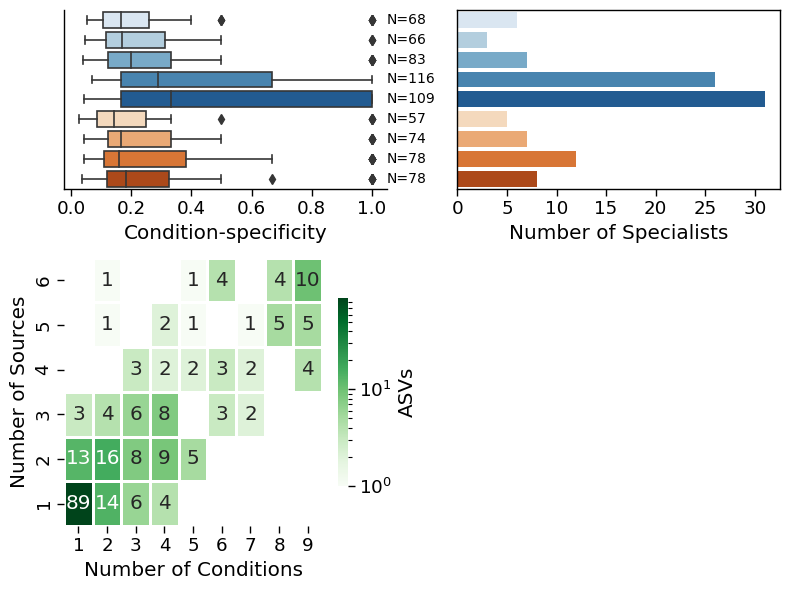

In [26]:
"Presence"
asv_post_T0 = asv[md.days.gt(0).pipe(lambda x: x[x]).index]
# Presence of each OTU in each sample
presence = asv_post_T0.gt(0).rename_axis(index='asv', columns='Sample').stack().reset_index(name='presence').merge(md.reset_index())

"Specilization"
# ASV distribution across number of conditions and sites
final_day_presence =  presence[presence.presence & presence.days.eq(33) & presence.is_site_rep]

mosaic = [['b', 'c'], ['a', '.']]
with sns.plotting_context('paper', font_scale=1.5):
    fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6), height_ratios=[1, 1.5])

    # Condition, site presence
    ax1 = axs['a']
    pres_condition_site = final_day_presence.groupby('asv')[['site', 'condition']].nunique().value_counts().unstack().fillna(0)
    pres_condition_site = pres_condition_site.reindex(pres_condition_site.index[::-1])

    sns.heatmap(pres_condition_site, cmap='Greens', norm=mpc.LogNorm(), lw=1, annot=True, fmt='.0f', cbar_kws={'label': 'ASVs', 'shrink': .7}, ax=ax1)
    ax1.set_xlabel('Number of Conditions')
    ax1.set_ylabel('Number of Sources')

    # Condition specificity
    ax2 = axs['b']
    condition_frac = final_day_presence.groupby('asv').condition.value_counts(normalize=True).reset_index(name='frac')
    n_condition_specialists = condition_frac.groupby('condition').asv.nunique()
    sns.boxplot(x='frac', y='condition', order=conditions.values(), data=condition_frac, palette=condition_pal, ax=ax2)
    # Annotate group sizes
    for y, condition in enumerate(conditions.values()):
        n_condition_specialists_group = n_condition_specialists.loc[condition]
        ax2.annotate(f'N={n_condition_specialists_group}', (1.05, y+.2), fontsize=10, color='k')
    ax2.set_ylabel('')
    ax2.set_yticks([])
    ax2.set_xlabel('Condition-specificity')
    sns.despine(ax=ax2)

    # Condition specialists
    ax3 = axs['c']
    condition_specialists = condition_frac[condition_frac.frac.eq(1)].condition.value_counts().rename_axis('condition').reset_index(name='counts')
    sns.barplot(x='counts', y='condition', order=conditions.values(), palette=condition_pal, data=condition_specialists, ax=ax3)
    ax3.set_ylabel('')
    ax3.set_yticks([])
    ax3.set_xlabel('Number of Specialists')

plt.tight_layout()
# plt.savefig('publication_figures/condition_specificity', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig('publication_figures/Fig4-a-c.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [212]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Figure4.xlsx') as fh:
    condition_frac.to_excel(fh, 'Fig 4a', index=False)
    condition_specialists.to_excel(fh, 'Fig 4b', index=False)
    pres_condition_site.astype(int).to_excel(fh, 'Fig 4c')

In [30]:
final_day_asv_site_condition = final_day_presence.groupby('asv')[['site', 'condition']].nunique()
generalists = final_day_asv_site_condition[final_day_asv_site_condition.site.eq(6) & final_day_asv_site_condition.condition.eq(9)].index
taxa.loc[generalists]

,Taxon,Consensus,Kingdom,Phylum,Class,Order,Family,Genus,Species
asv,,,,,,,,,
0e4b96294f2a2985a5d7fd8c87f7ce6d,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,0.600000,D_0__Bacteria,D_1__Bacteroidetes,D_2__Bacteroidia,D_3__Sphingobacteriales,D_4__Sphingobacteriaceae,D_5__Pedobacter,Ambiguous_taxa
20b3df08cd5fac2be26a2928155bab69,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.883333,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Betaproteobacteriales,D_4__Burkholderiaceae,D_5__Achromobacter,None
38c27ceaed634984c1225a82648cf571,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.558824,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Pseudomonadales,D_4__Pseudomonadaceae,D_5__Pseudomonas,Ambiguous_taxa
6376ea6dab7d0fde3cd66f53b57e1484,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.517857,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Pseudomonadales,D_4__Pseudomonadaceae,D_5__Pseudomonas,Ambiguous_taxa
63afe8e6aac58bf0d670a82ca5bc574c,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.666667,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Enterobacteriales,D_4__Enterobacteriaceae,D_5__Serratia,None
945184b6386c192c0066e0a98a154780,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.529095,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Enterobacteriales,D_4__Enterobacteriaceae,D_5__Enterobacter,None
da0bcb7477927763538ec7006a883728,D_0__Bacteria;D_1__Firmicutes;D_2__Bacilli;D_3...,1.000000,D_0__Bacteria,D_1__Firmicutes,D_2__Bacilli,D_3__Bacillales,D_4__Paenibacillaceae,D_5__Paenibacillus,None
f8aeec3c1ff0f4e7e1c829e4db0618d9,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,1.000000,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Pseudomonadales,D_4__Pseudomonadaceae,D_5__Pseudomonas,None
fb67b286b0f781b0de13d50179318995,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.555556,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Xanthomonadales,D_4__Xanthomonadaceae,D_5__Stenotrophomonas,D_6__uncultured bacterium


In [38]:
gen_abund.head()

,asv,Sample,abundance,condition_name,site,replicate,transfer,condition,days,condition_type,condition_number,depth,site_rep,is_site_rep,Cit,Glu,Cello,Cellu,Lignin
2994,38c27ceaed634984c1225a82648cf571,C10-HF1M15-R1-T10_S407,0.060219,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True
2995,945184b6386c192c0066e0a98a154780,C10-HF1M15-R1-T10_S407,0.003624,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True
2996,6376ea6dab7d0fde3cd66f53b57e1484,C10-HF1M15-R1-T10_S407,0.000000,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True
2998,63afe8e6aac58bf0d670a82ca5bc574c,C10-HF1M15-R1-T10_S407,0.085239,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True
2999,f8aeec3c1ff0f4e7e1c829e4db0618d9,C10-HF1M15-R1-T10_S407,0.513416,C10,HF1M15,R1,T10,Cit+Glu+Cello+Cellu+Lignin,33,mixed,10,11591,R1,True,True,True,True,True,True


In [ ]:
"Generalists abundances"
gen_abund = asv_normed_stacked[asv_normed_stacked.asv.isin(generalists) & asv_normed_stacked.days.eq(33) & asv_normed_stacked.is_site_rep]
sns.boxplot(x='asv', y='abundance', data=gen_abund)
plt.yscale('log')
plt.show()

# Figure 5: CRM

In [27]:
"Simulation results"
n_df = pd.read_csv('data/simulation/simulation_results_n_05-08_allT3.csv')
crm_md = pd.read_csv('data/simulation/CRM_md_05-08_allT3.csv', index_col=0)
total_abundance = n_df.groupby(['Sample', 'time']).abundance.sum().reset_index(name='total_abundance')
n_df = n_df.merge(total_abundance)
n_df['relative_abundance'] = n_df.abundance / n_df.total_abundance
# Remove super small abundances
n_df.loc[n_df.relative_abundance.lt(1e-7), 'relative_abundance'] = 0
n_df.loc[n_df.abundance.lt(1e-7), 'abundance'] = 0
n_df = n_df.merge(crm_md.reset_index())
n_final_time = n_df[n_df.time.eq(500)].reset_index(drop=True)

"Divergence"
# Normalize abundances between 0 and 8000 (random distribution of depth produces sam result)
minmax_normed = n_final_time.groupby('Sample', group_keys=False).apply(lambda x: pd.DataFrame(dict(zip(['Sample', 'species', 'normed'], [x.Sample, x.species, minmax_scale(x.abundance, (0, 8000))]))))
# Compute CLR transform
clred = minmax_normed.groupby('Sample', group_keys=False).apply(lambda x: pd.DataFrame(dict(zip(['Sample', 'species', 'clr'], [x.Sample, x.species, clr(x.normed.add(1))])))).merge(crm_md.reset_index())
# Compute distances
# all_dists = n_final_time.groupby(['scheme', 'condition']).apply(lambda x: longDists(x, values='relative_abundance'))
all_dists = clred.groupby(['scheme', 'condition']).apply(lambda x: longDists(x, values='clr'))
paired_dists = all_dists.reset_index()
paired_dists = paired_dists[paired_dists.sample1.ne(paired_dists.sample2)]
paired_dists_md = paired_dists.scheme.str.split('_', expand=True).rename(columns=dict(enumerate(['community_size', 'D_type', 'c_type'])))
paired_dists = paired_dists.join(paired_dists_md).astype({'community_size': int})
derep = derep_pairs(paired_dists)

"Divergence slopes"
derep['condition_type'] = derep.condition.str.contains('+', regex=False).map({True: 'Mixed', False: 'Single'})
order = ['T3', 'T2', 'T1', 'T0', 'T3+T2', 'T3+T2+T1', 'T3+T2+T1+T0']
derep['order'] = derep.condition.map({k: i for i, k in enumerate(order)})

# Compute linear regression for each
linregress_crm = derep.sort_values(['scheme', 'condition_type', 'order']).groupby(['scheme', 'D_type', 'condition_type']).apply(lambda x: pd.Series(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr'], linregress(x.order, x.dist, 'greater'))))).reset_index()
label_map = {'trophic': 'Trophic', 'noisy': 'Random'}
scheme2x = {scheme: '\n'.join([f'{label_map[n]} {mat}' for n, mat in zip(scheme.split('200_')[1].split('_'), ['R', 'C'])]) for scheme in crm_md.scheme.unique()}
linregress_crm['x_axis'] = linregress_crm.scheme.map(scheme2x)
linregress_crm['x_order'] = linregress_crm.scheme.map({k: i for i, k in enumerate([f'200_{d}_{c}' for d in ['trophic', 'noisy'] for c in ['trophic', 'noisy']])})
linregress_crm = linregress_crm.sort_values('x_order')
derep.head()

,scheme,condition,sample1,sample2,dist,community_size,D_type,c_type,condition_type,order
0,200_noisy_noisy,T0,S115,S143,48.614749,200,noisy,noisy,Single,3
1,200_noisy_noisy,T0,S115,S3,49.708072,200,noisy,noisy,Single,3
2,200_noisy_noisy,T0,S115,S31,46.251621,200,noisy,noisy,Single,3
3,200_noisy_noisy,T0,S115,S59,49.036654,200,noisy,noisy,Single,3
4,200_noisy_noisy,T0,S115,S87,51.540844,200,noisy,noisy,Single,3


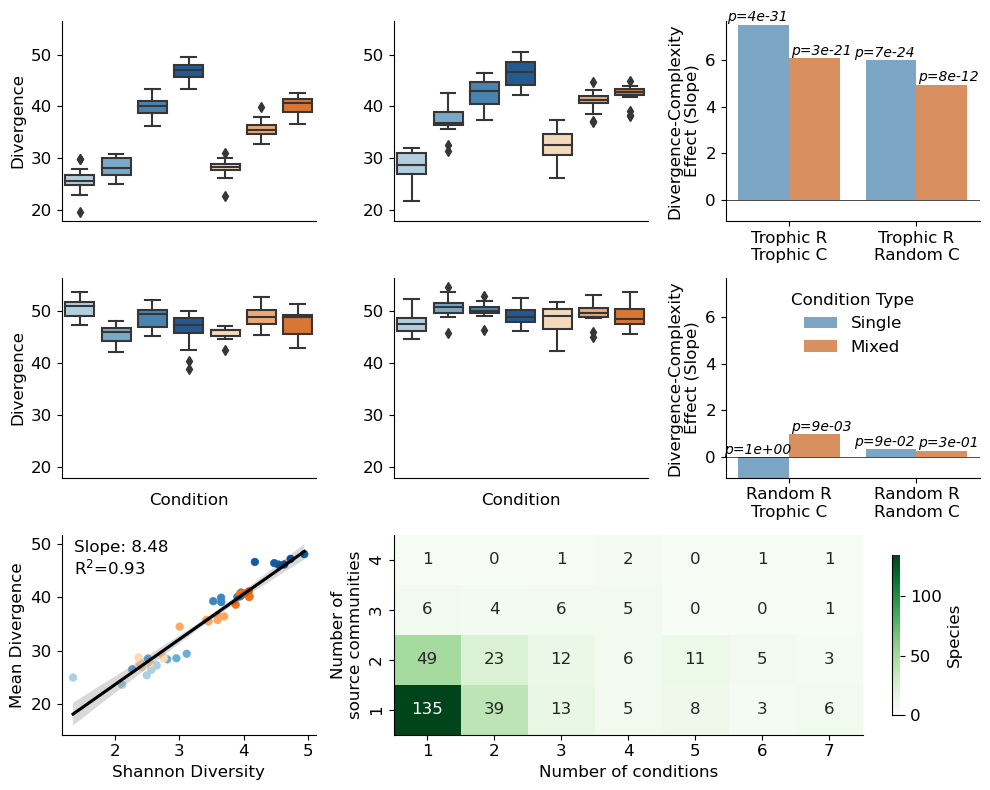

In [28]:
"Divergence and slopes"
mosaic = [
    ['200_trophic_trophic', '200_trophic_noisy', 't_bars'],
    ['200_noisy_trophic', '200_noisy_noisy', 'r_bars'],
    ['div', 'pres', 'pres']
]
with plt.rc_context({'font.size': 12}):
    fig, axs = plt.subplot_mosaic(mosaic, figsize=(10, 8), layout='tight')
    
    "Divergence by condition"
    order = ['T3', 'T2', 'T1', 'T0', 'T3+T2', 'T3+T2+T1', 'T3+T2+T1+T0']
    crm_condition_pal = dict(zip(order, list(condition_pal.values())[1:]))
    for d in ['trophic', 'noisy']:
        x_label = '' if d == 'trophic' else 'Condition'
        for c in ['trophic', 'noisy']:
            scheme = f'200_{d}_{c}'
            crm_div_data = derep[derep.scheme.eq(scheme)]
            ax = axs[scheme]
            sns.boxplot(x='condition', y='dist', data=crm_div_data, palette=crm_condition_pal, ax=ax, order=order)
            ax.set_xticklabels([])
            ax.set_xlabel(x_label)
            ax.set_ylabel('Divergence')
            ax.sharey(axs['200_noisy_noisy'])
            ax.tick_params(axis='x', bottom=False)
            
            if c == 'noisy':
                ax.set_ylabel('')
    
    "Slope for each"
    # Visualize
    order = ['Trophic R\nTrophic C', 'Trophic R\nRandom C', 'Random R\nTrophic C', 'Random R\nRandom C']
    single_color = np.mean([v for k, v in condition_pal.items() if '+' not in k], 0)
    mixed_color = np.mean([v for k, v in condition_pal.items() if '+' in k], 0)
    single_mixed_pal = dict(zip(['Single', 'Mixed'], [single_color, mixed_color]))
    
    pval_y_boost = .15
    for d, ax_name in zip(['trophic', 'noisy'], ['t_bars', 'r_bars']):
        ax = axs[ax_name]
        crm_slope_data = linregress_crm[linregress_crm.D_type.eq(d)]
        sns.barplot(x='x_axis', y='slope', hue='condition_type', data=crm_slope_data, hue_order=['Single', 'Mixed'], palette=single_mixed_pal, ax=ax)
        # Plot p-values
        for i, x_axis in enumerate(crm_slope_data.x_axis.unique()):
            for offset, condition in enumerate(['Single', 'Mixed']):
                crm_stats = crm_slope_data[crm_slope_data.x_axis.eq(x_axis) & crm_slope_data.condition_type.eq(condition)].squeeze()
                pval = f'p={crm_stats.pvalue:.0e}'
                slope = crm_stats.slope + pval_y_boost
                if slope < 0:
                    slope = pval_y_boost
                x_pos = i - .25 + offset * .5
                ax.annotate(pval, (x_pos, slope), fontsize=10, horizontalalignment='center', fontstyle='italic')
        # ax.sharey(axs['t_bars'])
        ylim = linregress_crm.slope.agg(['min', 'max']) + [0, pval_y_boost]
        # ax.set_ylim(*linregress_crm.slope.agg(['min', 'max']))
        ax.set_ylim(ylim)
        ax.axhline(0, color='k', lw=.5)
        ax.set_ylabel('Divergence-Complexity\nEffect (Slope)')
        ax.set_xlabel('')
        
        if d == 'noisy':
            ax.legend(frameon=False, title='Condition Type', loc='upper center')
        else:
            ax.get_legend().set_visible(False)
    "CRM Divergence and Diversity"
    crm_shannon = n_final_time[n_final_time.scheme.eq('200_trophic_trophic')].groupby(['Sample', 'community', 'condition']).abundance.apply(shannon).reset_index(name='shannon')
    paired_dists_crm_md = pair_md(all_dists.reset_index(), crm_md.reset_index(), wideform=False)
    crm_mean_divergence = paired_dists_crm_md[paired_dists_crm_md.scheme.eq('200_trophic_trophic') & ~paired_dists_crm_md.same_Sample].groupby(['condition', 'sample1_community']).dist.mean().reset_index().rename(columns={'sample1_community': 'community'})
    crm_shannon_divergence = crm_mean_divergence.merge(crm_shannon)
    linregress_crm_shannon_divergence = linregress(crm_shannon_divergence[['shannon', 'dist']])
    
    ax = axs['div']
    kwargs = dict(x='shannon', y='dist', data=crm_shannon_divergence, ax=ax)
    sns.scatterplot(**kwargs, hue='condition', palette=crm_condition_pal, legend=False, edgecolor=None, s=30)
    sns.regplot(**kwargs, scatter=False, color='k')
    ax.set_ylabel('Mean Divergence')
    ax.set_xlabel('Shannon Diversity')
    annot = f"""Slope: {linregress_crm_shannon_divergence.slope:.2f}
R$^2$={linregress_crm_shannon_divergence.rvalue**2:.2f}"""
    ax.annotate(annot, (.05, .8), xycoords='axes fraction')
    
    "Presence"
    n_final_time['presence'] = n_final_time.abundance.gt(0)
    pres_condition_comm_crm = n_final_time[n_final_time.scheme.eq('200_trophic_trophic') & n_final_time.presence].groupby('species')[['community', 'condition']].nunique().value_counts().unstack().fillna(0)
    pres_condition_comm_crm = pres_condition_comm_crm.reindex(pres_condition_comm_crm.index[::-1])
    
    ax = axs['pres']
    sns.heatmap(pres_condition_comm_crm, cmap='Greens', annot=True, ax=ax, cbar_kws={'shrink': .8, 'format': '{x:.0f}', 'label': 'Species'}, fmt='.0f')
    ax.set_xlabel('Number of conditions')
    ax.set_ylabel('Number of\nsource communities')
sns.despine()
# plt.savefig('publication_figures/crm_combined_results', dpi=300, transparent=True, bbox_inches=False)
plt.savefig('publication_figures/Fig5-a-h.pdf', dpi=300, transparent=True, bbox_inches=False)
plt.show()

In [29]:
"Save source data"
with pd.ExcelWriter('publication_figures_source_data/Figure5.xlsx') as fh:
    derep.rename(columns={'D_type': 'transformation_type', 'c_type': 'preference_type'}).to_excel(fh, 'Fig 5a-d', index=False)
    linregress_crm.drop('D_type', axis=1).to_excel(fh, 'Fig 5e-f', index=False)
    crm_shannon_divergence.to_excel(fh, 'Fig 5g', index=False)
    pres_condition_comm_crm.astype(int).to_excel(fh, 'Fig 5h')

# Supplementary figure: Stabilization

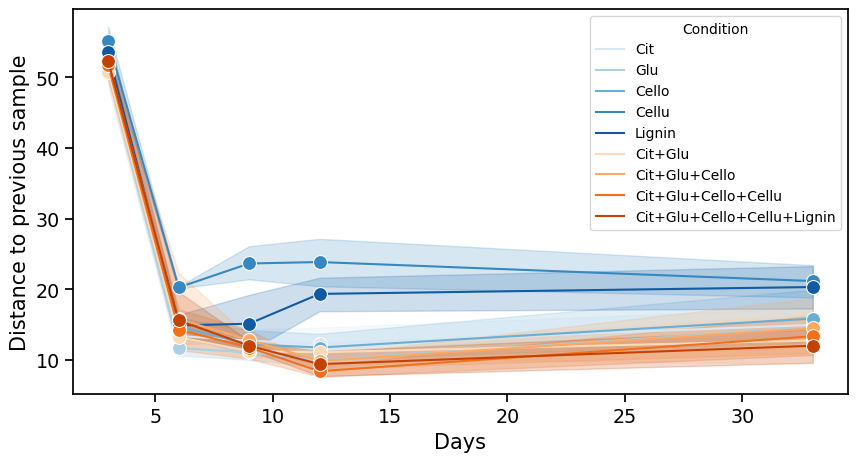

In [20]:
"Stabilization (change in community between transfers)"
# sorted_days = md[['site', 'days']].drop_duplicates().sort_values('days').groupby('site').days.unique().apply(list)
sorted_days = sorted(md.days.unique())

t1_same_condition_onward = paired[paired.sample1_days.gt(0) & paired.same_condition & paired.same_site & (~paired.same_Sample) & paired.sample1_is_site_rep & paired.same_is_site_rep]
# Serial distance between Sample 1 and Sample 2
# stability_dists = t1_same_condition_onward[t1_same_condition_onward.sample2_days.eq(t1_same_condition_onward.apply(lambda x: sorted_days[x.sample1_site][sorted_days[x.sample1_site].index(x.sample1_days) - 1], axis=1))]
stability_dists = t1_same_condition_onward[t1_same_condition_onward.sample2_days.eq(t1_same_condition_onward.sample1_days.apply(lambda x: sorted_days[sorted_days.index(x)-1]))]


plt.figure(figsize=(10, 5))
with sns.plotting_context('notebook', font_scale=1.25):
    sns.lineplot(x='sample1_days', y='distance', hue='sample1_condition', data=stability_dists, palette=condition_pal, marker='o', hue_order=conditions.values(), ms=10)
    plt.xlabel('Days')
    plt.ylabel('Distance to previous sample')
plt.legend(bbox_to_anchor=(1, 1), title='Condition')
# plt.savefig('publication_figures/stability_timeseries.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
"Save source data"
stability_dists[['sample1', 'sample2', 'distance', 'sample1_condition', 'sample1_site', 'sample1_days', 'sample2_days']].rename(
    columns={'sample1_condition': 'condition'}).to_excel('publication_figures_source_data/Extended_Data_Figure1.xlsx', 'Extended Fig 1', index=False)

# Supplementary figure: Family bars

In [41]:
"Collapse"
levels = ['Phylum', 'Family']

collapsed_dict = {l: collapse(asv_normed, taxa, l) for l in levels}

"Plot stacked bars"
unassigned_name = 'Unassigned'
rename_unassigned = ['Ambiguous_taxa', 'D_4__uncultured', 'D_4__uncultured bacterium', 'D_4__uncultured soil bacterium', 'D_4__uncultured forest soil bacterium']

for level, level_data in collapsed_dict.items():
    # Combine unassigned
    level_data = level_data.rename(index={u: unassigned_name for u in rename_unassigned})
    
    # Add "Other"
    level_means = level_data.mean(1).sort_values(ascending=False)
    level_order = [i for i in level_means.index if i != unassigned_name]
    top_n = 8
    level_top = level_order[:top_n]
    level_data['label'] = [x if x in level_top else 'Other' for x in level_data.index]
    level_othered = level_data.groupby('label')[asv.columns].sum()
    
    # Add remaining unassigned
    remaining_unassigned = 1-level_othered.sum().rename(unassigned_name)
    if unassigned_name in level_othered.index:
        level_othered.loc[unassigned_name] += remaining_unassigned
    else:
        level_othered = level_othered.append(remaining_unassigned)
        
    # Create palette
    level_stack_order = list(level_top) + ['Other', 'Unassigned']
    if level == 'Phylum':
        level_pal = dict(zip(level_stack_order, sns.color_palette()))
    else: # For Family, create stratified palette per phylum 
        phylum2family = taxa.loc[taxa.Family.isin(level_stack_order), ['Phylum', 'Family']].groupby('Phylum').Family.unique().apply(lambda x: [i for i in level_stack_order if i in x])
        phylumpal = dict(zip(phylum2family.keys(), sns.color_palette()))
        # Create family pal by brightening phylum pal
        max_phylum_size = phylum2family.apply(lambda x: len(x)).max()
        level_pal = {k: v  for p, f in phylum2family.items() for k, v in dict(zip(f, np.clip(np.linspace(.6, 1.3, max_phylum_size)[::-1].reshape(-1, 1) * phylumpal[p], 0, 1))).items()}

    level_pal.update({'Other': '.5', 'Unassigned': 'k'})
    # Stack
    level_stacked = level_othered.rename_axis(columns='Sample').stack().reset_index('label', name='abundance').join(md)

    # Plot
    level_stackbar_data = level_stacked[level_stacked.is_site_rep].sort_values(['site', 'condition', 'days'])
    g = sns.FacetGrid(data=level_stackbar_data, row='condition', col='site', height=2.5, margin_titles=True, row_order=conditions.values(), col_order=sites, sharex=False)
    g.map_dataframe(long_stackedbarplot, 'label', 'days', 'abundance', stack_order=level_stack_order, palette=level_pal)
    g.set_ylabels('Abundance')
    g.set_xlabels('Days')
    # Legend
    if level == 'Phylum':
        handles = {l: Patch(label=l, color=c) for l, c in level_pal.items()}
    else:
        handles = {}
        spaces = 0
        for p, fs in phylum2family.items():
            handles[p] = Patch(color='w')
            for f in fs:
                handles[f] = Patch(color=level_pal[f])
            handles[' '*spaces] = Patch(color='w')
            spaces += 1
        handles.update({x: Patch(color=c) for x, c in {'Other': '.5', 'Unassigned': 'k'}.items()})


    g.add_legend(handles, level)
    g.set_titles(col_template='{col_name}', row_template='{row_name}')
    # plt.savefig(f'publication_figures/bars_{level}.pdf', bbox_inches='tight', dpi=300)
    plt.close()

/scratch/249064.1.ood/ipykernel_3090100/2768977342.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  level_othered = level_othered.append(remaining_unassigned)
/scratch/249064.1.ood/ipykernel_3090100/2768977342.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  level_othered = level_othered.append(remaining_unassigned)


In [46]:
"Save source data"
level_stackbar_data[['label', 'abundance', 'condition', 'days']].to_excel('publication_figures_source_data/Extended_Data_Figure4.xlsx', 'Extended Fig 4')